## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'agriVision-full' 
TRANSFORM = 'fourier'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_fourier_full_agriVision.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/agriVision/full/fourier/gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 45000,
 3: 72000,
 4: 63000,
 5: 117000,
 6: 126000,
 7: 171000,
 8: 189000,
 9: 297000,
 10: 396000,
 11: 495000,
 12: 648000,
 13: 882000,
 14: 1134000,
 15: 1539000,
 16: 1953000,
 17: 2574000,
 18: 3456000,
 19: 4563000,
 20: 5967000,
 21: 8010000,
 22: 10395000,
 23: 13887000,
 24: 18297000,
 25: 24057000,
 26: 31968000,
 27: 42183000,
 28: 55764000,
 29: 73701000,
 30: 97326000,
 31: 108342000,
 32: 59634000,
 33: 21420000}

Running 12760 CDFs


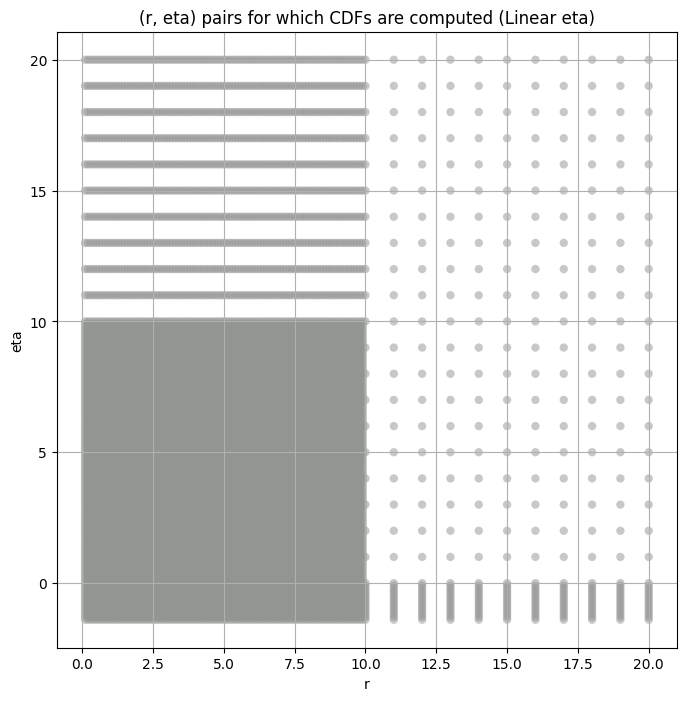

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 17


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 20


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 23


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 26


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 29


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 32


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var   var_lower    var_upper     obs_kurt  kurt_lower  \
band                                                                  
2     1021.589840  632.272500  1625.946700    360.00027  103.517940   
5      613.385000  337.520480  1441.568100   1149.93900   99.624860   
8      207.881040  118.970184   419.744200    744.87524   90.633835   
11     118.822140   50.023308   488.236450   5619.66460   83.865580   
14      40.410416   20.525957   130.472370   2531.13770   77.299590   
17      25.864876    9.595861   151.859590  11999.47100   68.112076   
20      13.953182    5.587813    65.674805   7428.83840   72.217384   
23       6.573230    2.182701    44.126280  17039.29100   63.021640   
26       3.953361    0.617809    40.390670  33131.47300   70.198720   
29       0.418982    0.077271     3.418306  27537.83200   85.778534   
32       0.013868    0.008013     0.031387   1045.78520   83.576560   

      kurt_upper  total_samples  
band                             
2       707.7830        45000.0  
5      3055.2026       117000.0  
8      2225.1548       189000.0  
11     6158.5415       495000.0  
14     4791.7000      1134000.0  
17     7838.7065      2574000.0  
20     6734.7490      5967000.0  
23     8338.4800     13887000.0  
26     9346.5490     31968000.0  
29     9120.4880     73701000.0  
32     2666.2980     59634000.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                               
2     1021.589840    1021.589844      549.864319      430.076172   
5      613.385000     613.385010      359.295837      300.796753   
8      207.881040     207.881042      126.801811      107.194206   
11     118.822140     118.822144       52.870029       44.941616   
14      40.410416      40.410416       21.664782       18.516623   
17      25.864876      25.864876       10.107347        8.710735   
20      13.953182      13.953182        5.893808        5.059303   
23       6.573230       6.573230        2.286716        1.986188   
26       3.953361       3.953361        0.649722        0.560040   
29       0.418982       0.418982        0.081994        0.069247   
32       0.013868       0.013868        0.008482        0.007172   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2         370.751526       335.546509       291.646454       264.597565   
5         264.481201       241.009674       208.062592       186.286026   
8          95.282822        86.757713        75.509842        68.247704   
11         40.210251        36.991066        32.688606        29.874626   
14         16.683149        15.409375        13.743671        12.677200   
17          7.902018         7.355671         6.640939         6.184279   
20          4.577019         4.248333         3.819817         3.544424   
23          1.811499         1.692909         1.538012         1.437293   
26          0.508072         0.472625         0.425832         0.395025   
29          0.062046         0.057297         0.051236         0.047309   
32          0.006439         0.005964         0.005364         0.004974   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2          244.823242       228.884903       215.902435       187.276337  
5          170.645721       159.046967       149.788452       130.038864  
8           63.071529        59.187294        56.017433        49.118698  
11          27.890636        26.369411        25.136089        22.478914  
14          11.919566        11.345743        10.883990         9.885197  
17           5.857204         5.605971         5.401327         4.947982  
20           3.346468         3.193051         3.068001         2.789619  
23           1.363017         1.303770         1.254199         1.139850  
26           0.372140         0.353888         0.338643         0.303613  
29           0.044391         0.042055         0.040098         0.035586  
32           0.004681         0.004444         0.004243         0.003774

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.032399208147136205 1021.58984


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.020333488659505683 549.8643


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.015057574471793317 430.07617


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.01266598672676511 370.75153


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.010510680396022543 335.5465


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.009179437143605362 291.64645


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.009087586816409199 264.59756


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.00988593126553916 244.82324


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.011322080218995834 228.8849


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.012625189568924888 215.90244


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.016375194987008568 187.27634
Number of samples: 45000, Without approximation : 45000.0


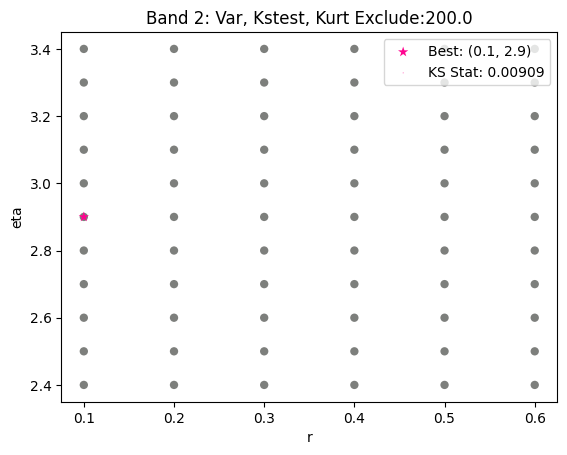

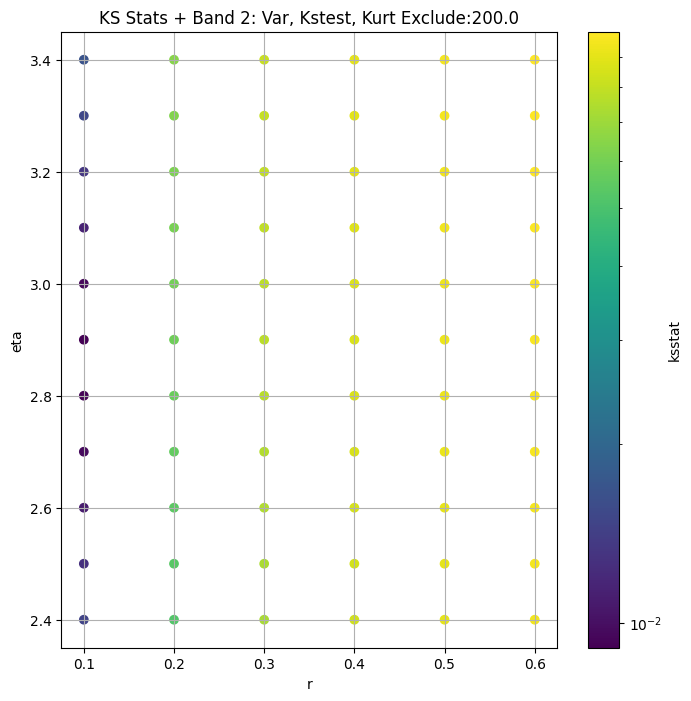

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.033625786272633115 613.385


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.024561701664634894 359.29584


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.021516296680260075 300.79675


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.017977120192364526 264.4812


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.016213086217628667 241.00967


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.013498481922939454 208.06259


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.011143382674430796 186.28603


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.009312653889913619 170.64572


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.008200651186679786 159.04697


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.00664940126190261 149.78845


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.007464724261871725 130.03886
Number of samples: 100000, Without approximation : 117000.0


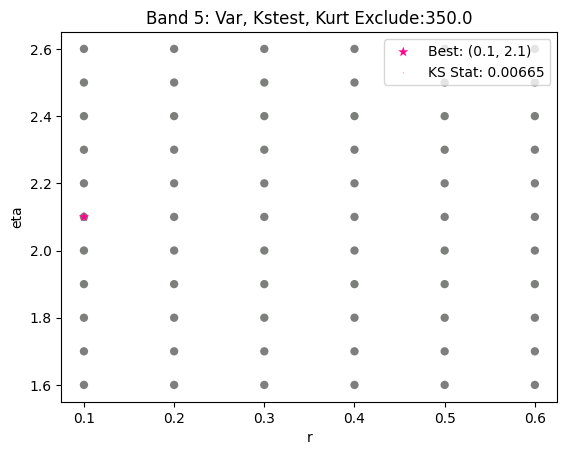

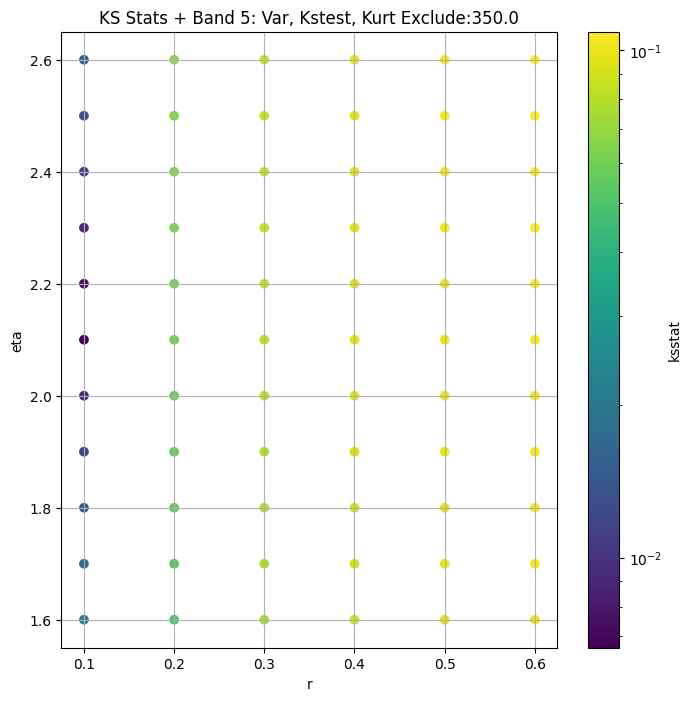

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.03268358972472435 207.88104


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.023746705066180263 126.80181


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.01967753863387825 107.19421


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.016952639946124476 95.28282


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.015046889129365984 86.75771


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.012513920654395938 75.50984


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.009972397224695118 68.2477


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.007808329162141109 63.07153


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.006658332263511424 59.187294


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.005866230797214933 56.017433


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.007305385046014745 49.1187
Number of samples: 100000, Without approximation : 189000.0


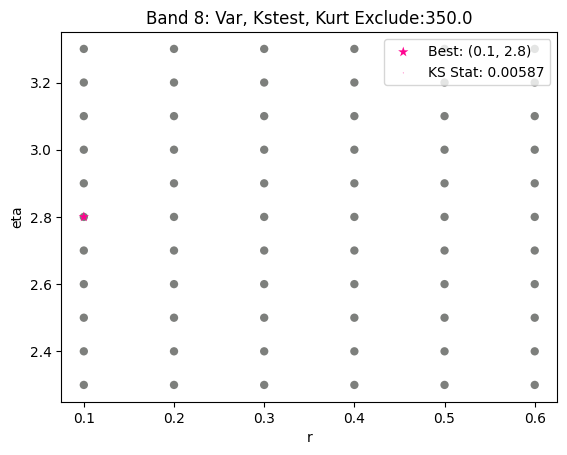

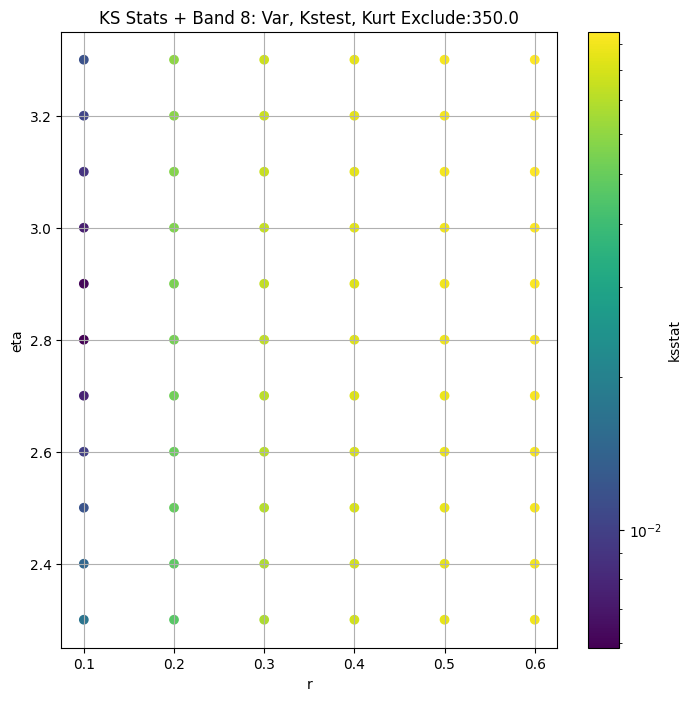

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.03492264552529989 118.82214


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.019531200550849864 52.87003


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.015374334983730018 44.941616


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.012906269739806353 40.21025


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.010602947062114218 36.991066


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.007422988729895552 32.688606


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.005161213589092828 29.874626


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.003920136625429227 27.890636


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.004488959948444227 26.369411


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.004995082998215383 25.13609


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.006693649970962556 22.478914
Number of samples: 100000, Without approximation : 495000.0


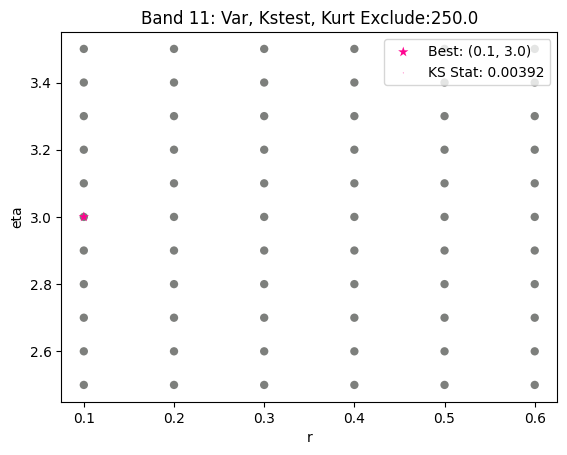

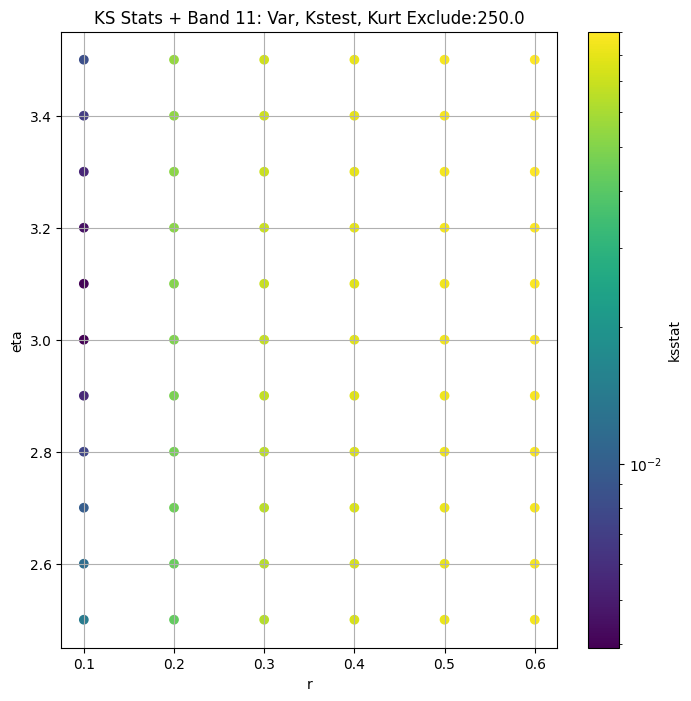

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.02871694080525833 40.410416


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.016010259498971946 21.664782


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.01179019176386048 18.516623


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.0093476528849461 16.68315


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.006889063509086857 15.409375


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.00357672939719067 13.743671


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.002749478770597169 12.6772


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.003253597561713728 11.919566


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.00385828148550027 11.345743


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.004536895162982724 10.88399


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.006437138215738436 9.885197
Number of samples: 100000, Without approximation : 1134000.0


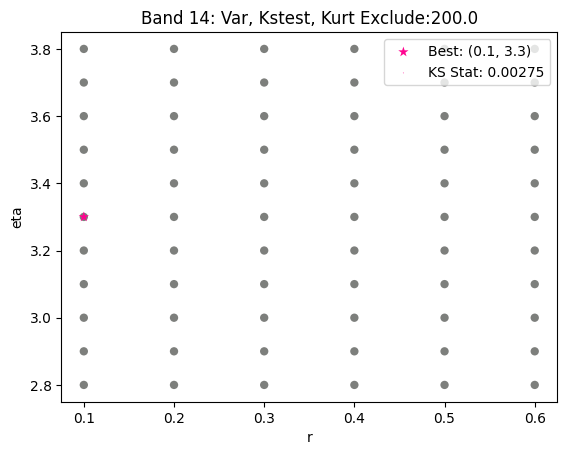

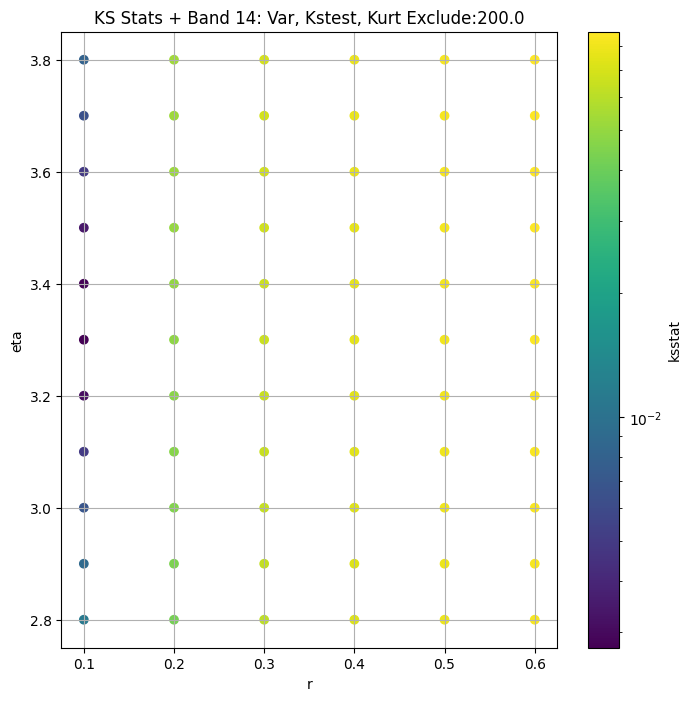

####
Band  17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 0 0.033194750891547 25.864876


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 25 0.012247813623980197 10.107347


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 50 0.00872394858609038 8.710735


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 75 0.0065077570276086405 7.902018


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 100 0.004344465607965864 7.3556714


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 150 0.0020961049739335767 6.640939


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 200 0.002566515146263694 6.1842794


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 250 0.003326457237056266 5.857204


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 300 0.00399953593341318 5.6059713


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 350 0.004794075498807612 5.4013267


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 500 0.006802203345384481 4.947982
Number of samples: 100000, Without approximation : 2574000.0


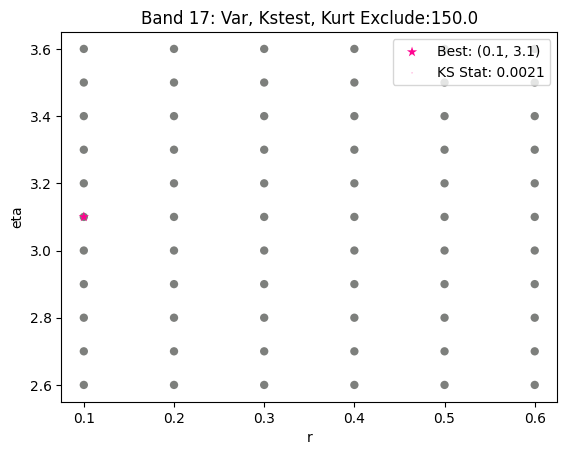

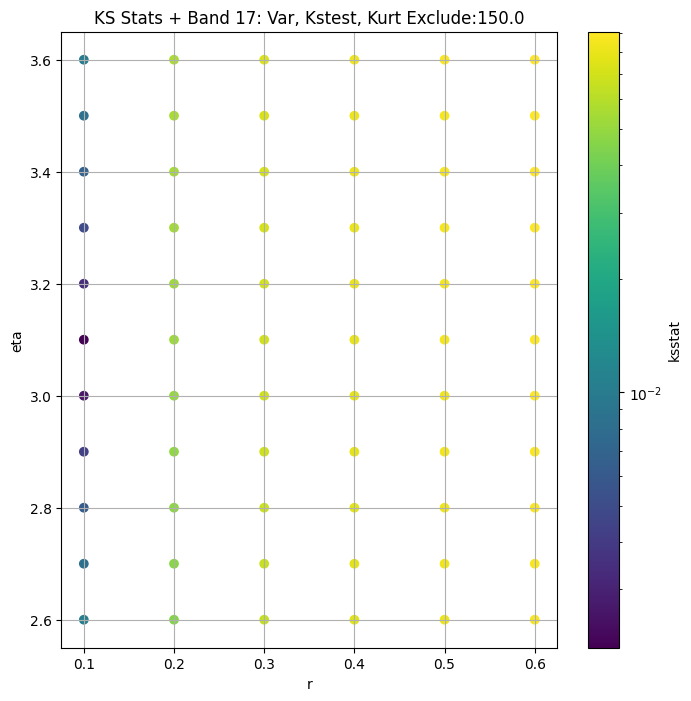

####
Band  20


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 0 0.030163878722339388 13.953182


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 25 0.01307678950994906 5.8938084


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 50 0.01009590683471473 5.0593033


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 75 0.007862499907074327 4.5770187


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 100 0.00613162332549555 4.2483325


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 150 0.004298868541809997 3.819817


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 200 0.003041734629836158 3.5444243


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 250 0.004250727752930436 3.3464677


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 300 0.004804685062728714 3.1930509


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 350 0.005386439196328328 3.068001


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 500 0.007369560158047541 2.789619
Number of samples: 100000, Without approximation : 5967000.0


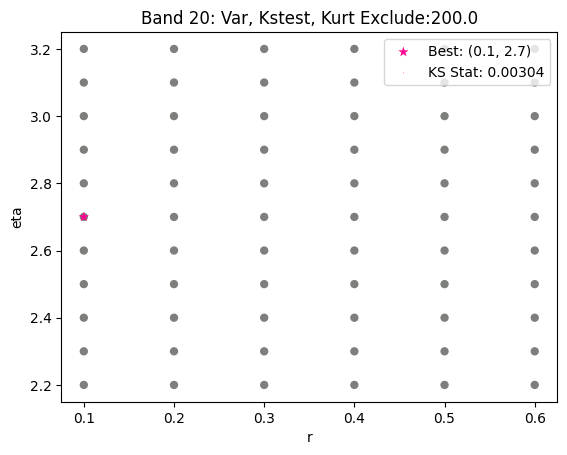

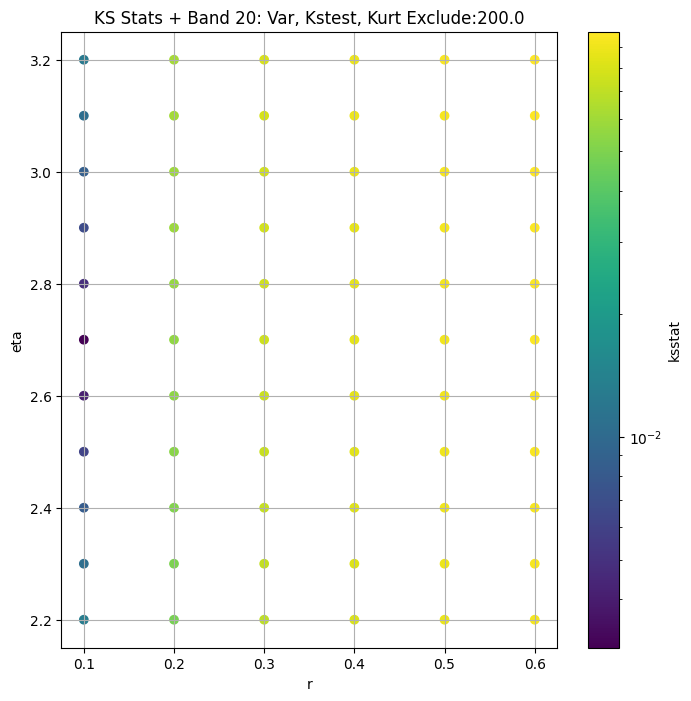

####
Band  23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 0 0.034723916658437104 6.57323


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 25 0.01300754713927682 2.2867157


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 50 0.01040629504627466 1.9861884


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 75 0.00849860650478873 1.8114988


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 100 0.007936283811117661 1.6929088


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 150 0.005750682531199869 1.538012


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 200 0.004685369978306209 1.4372928


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 250 0.005241547837114391 1.363017


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 300 0.005588506326791642 1.3037697


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 350 0.0064571668960019535 1.2541989


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 500 0.00803217681237367 1.1398505
Number of samples: 100000, Without approximation : 13887000.0


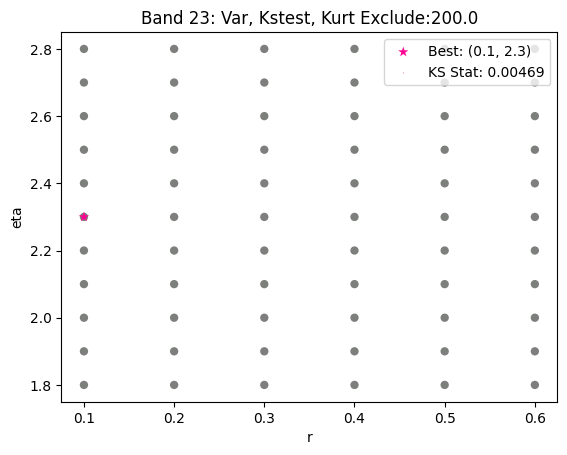

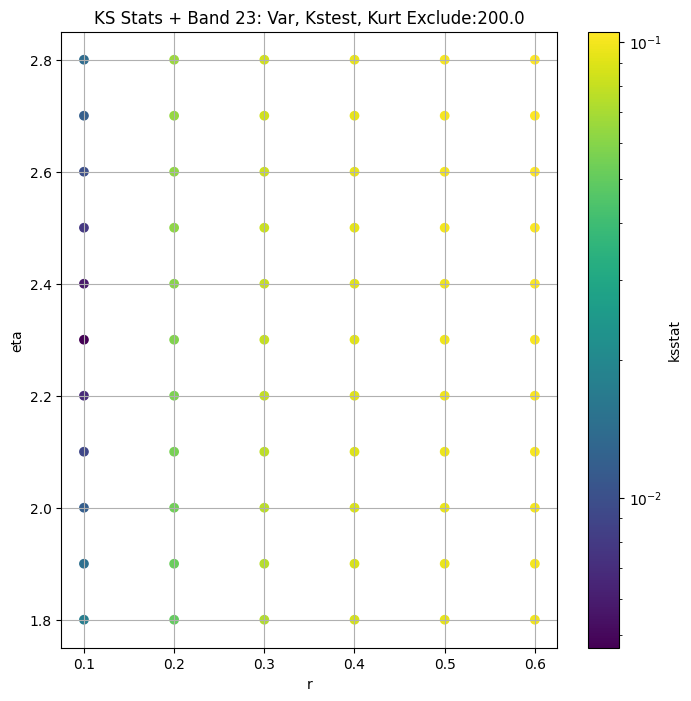

####
Band  26


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 0 0.046544370367142804 3.9533613


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 25 0.015411108436438004 0.6497219


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 50 0.01253508319357488 0.5600405


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 75 0.009366803442547034 0.50807196


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 100 0.008877540940605444 0.47262505


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 150 0.006830104382719249 0.4258317


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 200 0.0058392951361060375 0.39502478


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 250 0.005867606388021973 0.37214047


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 300 0.006765149140874449 0.3538876


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 350 0.006997320516524574 0.33864278


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 500 0.00865400650854975 0.30361322
Number of samples: 100000, Without approximation : 31968000.0


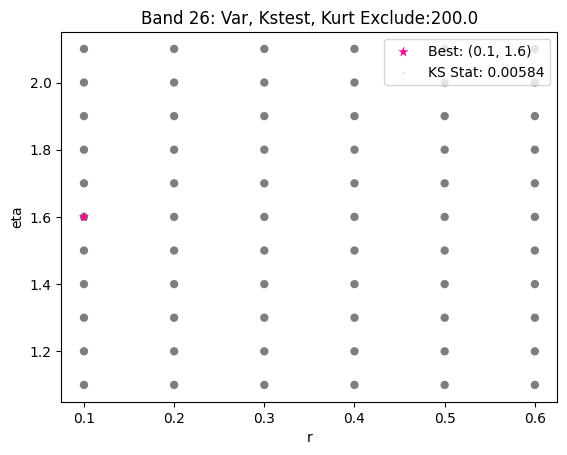

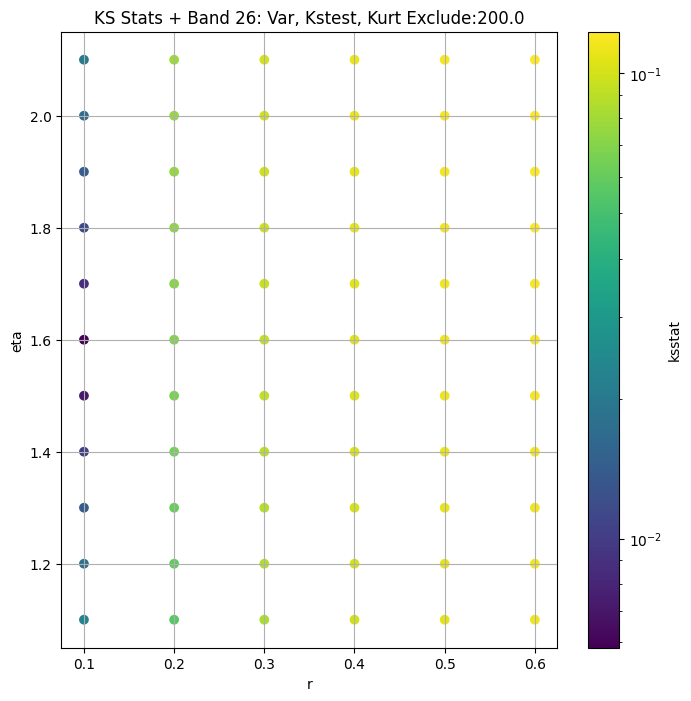

####
Band  29


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 0 0.0397649068372299 0.41898188


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 25 0.01987435098244572 0.08199434


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 50 0.01561432063714166 0.069246516


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 75 0.013656025545077166 0.06204648


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 100 0.01289781543322735 0.057297282


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 150 0.01188815154077072 0.05123621


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 200 0.010881000109855266 0.04730916


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 250 0.009528167842302482 0.04439129


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 300 0.008782651588489565 0.042054906


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 350 0.00963875617754728 0.040098343


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 500 0.011832449080746765 0.035585783
Number of samples: 100000, Without approximation : 73701000.0


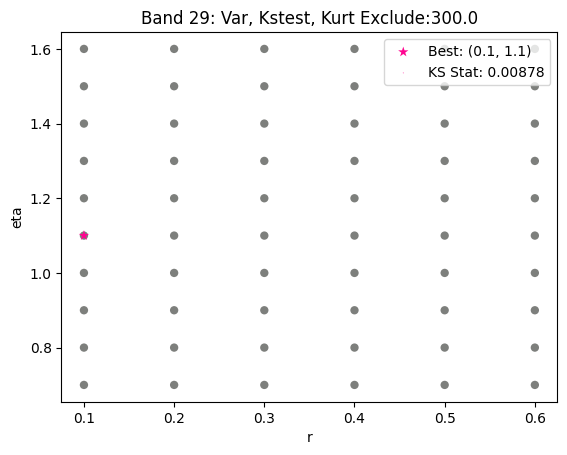

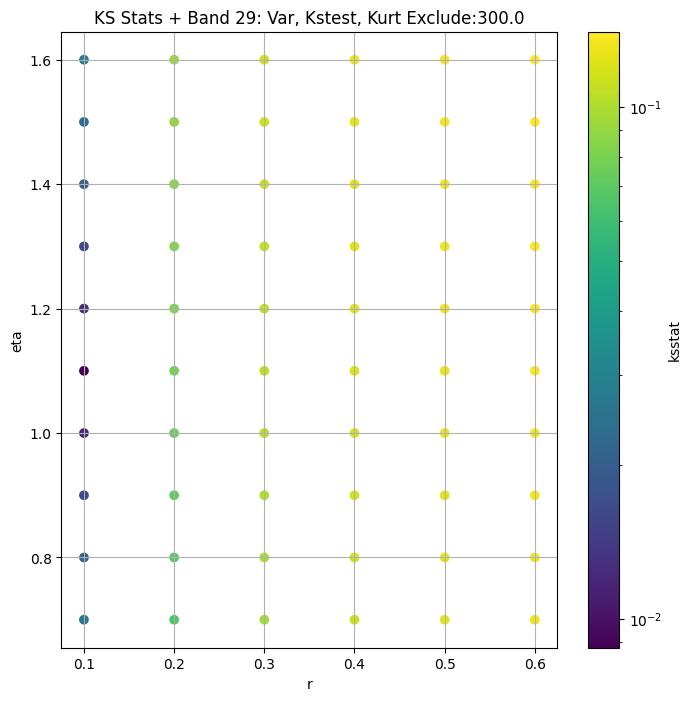

####
Band  32


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
32 0 0.0317258689586436 0.013868322


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
32 25 0.025039717469837908 0.008481597


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
32 50 0.02152649792475425 0.0071715317


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
32 75 0.020122672113765838 0.0064392546


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
32 100 0.018512026845268537 0.0059640557


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
32 150 0.0169090106864061 0.0053637167


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
32 200 0.015591951965975737 0.004973554


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
32 250 0.014202197110409154 0.004680678


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
32 300 0.013247692877130679 0.0044436017


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
32 350 0.012562133357590044 0.0042429967


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
32 500 0.010923426640344569 0.0037743447
Number of samples: 100000, Without approximation : 59634000.0


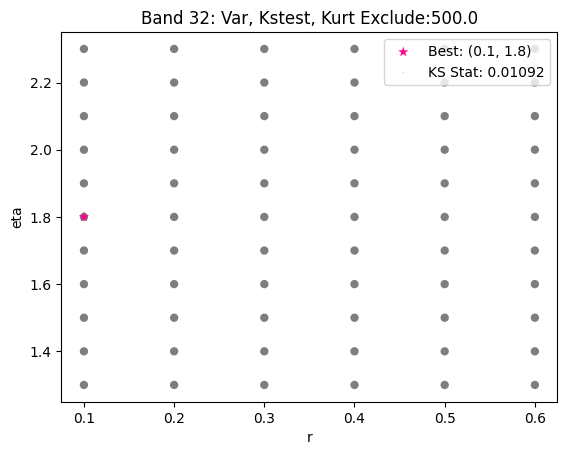

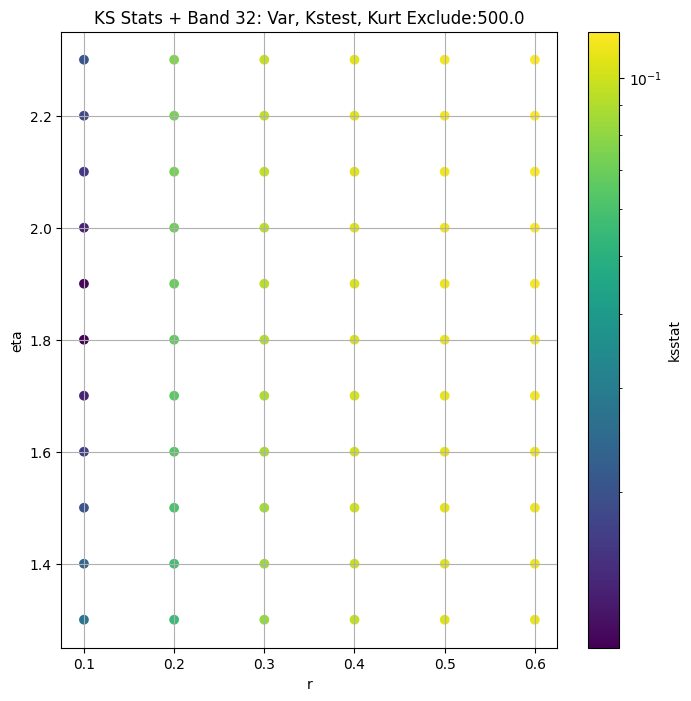

obs_var   var_lower    var_upper     obs_kurt  kurt_lower  \
band                                                                  
2     1021.589840  632.272500  1625.946700    360.00027  103.517940   
5      613.385000  337.520480  1441.568100   1149.93900   99.624860   
8      207.881040  118.970184   419.744200    744.87524   90.633835   
11     118.822140   50.023308   488.236450   5619.66460   83.865580   
14      40.410416   20.525957   130.472370   2531.13770   77.299590   
17      25.864876    9.595861   151.859590  11999.47100   68.112076   
20      13.953182    5.587813    65.674805   7428.83840   72.217384   
23       6.573230    2.182701    44.126280  17039.29100   63.021640   
26       3.953361    0.617809    40.390670  33131.47300   70.198720   
29       0.418982    0.077271     3.418306  27537.83200   85.778534   
32       0.013868    0.008013     0.031387   1045.78520   83.576560   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2       707.7830        45000.0             0.009088        0.1          2.9   
5      3055.2026       117000.0             0.006649        0.1          2.1   
8      2225.1548       189000.0             0.005866        0.1          2.8   
11     6158.5415       495000.0             0.003920        0.1          3.0   
14     4791.7000      1134000.0             0.002749        0.1          3.3   
17     7838.7065      2574000.0             0.002096        0.1          3.1   
20     6734.7490      5967000.0             0.003042        0.1          2.7   
23     8338.4800     13887000.0             0.004685        0.1          2.3   
26     9346.5490     31968000.0             0.005839        0.1          1.6   
29     9120.4880     73701000.0             0.008783        0.1          1.1   
32     2666.2980     59634000.0             0.010923        0.1          1.8   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      3.739454e-15                   200.0          264.597560   
5      1.293895e-14                   350.0          149.788450   
8      9.757825e-16                   350.0           56.017433   
11     3.211735e-16                   250.0           27.890636   
14     8.089977e-17                   200.0           12.677200   
17     6.256921e-17                   150.0            6.640939   
20     7.644157e-17                   200.0            3.544424   
23     7.649175e-17                   200.0            1.437293   
26     1.284220e-16                   200.0            0.395025   
29     6.312912e-17                   300.0            0.042055   
32     7.068627e-19                   500.0            0.003774   

      kstest_stat_cutoff_0.05  
band                           
2                    0.006398  
5                    0.003969  
8                    0.003123  
11                   0.001930  
14                   0.001275  
17                   0.000846  
20                   0.000556  
23                   0.000364  
26                   0.000240  
29                   0.000158  
32                   0.000176

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 200.0 + 100 = 300, ksstat: 0.01283231397030693, var: 228.88490295410156


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 200.0 + 75 = 275, ksstat: 0.011940705253218997, var: 236.42852783203125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 200.0 + 50 = 250, ksstat: 0.010966851239618602, var: 244.8232421875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 200.0 + 25 = 225, ksstat: 0.010005485492930122, var: 254.18679809570312


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 200.0 + 0 = 200, ksstat: 0.008926819960780263, var: 264.5975646972656


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 200.0 + -25 = 175, ksstat: 0.008745503824507339, var: 276.9102478027344


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 200.0 + -50 = 150, ksstat: 0.00895900402182681, var: 291.6464538574219


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 200.0 + -75 = 125, ksstat: 0.009177419027491585, var: 310.13848876953125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 200.0 + -100 = 100, ksstat: 0.010000383651439931, var: 335.5465087890625
Number of samples: 45000, Without approximation : 45000.0


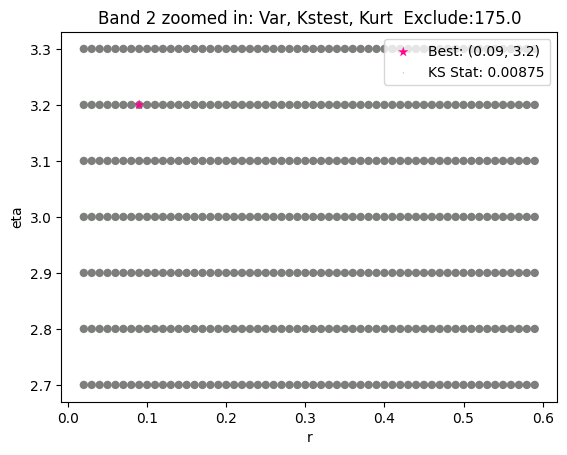

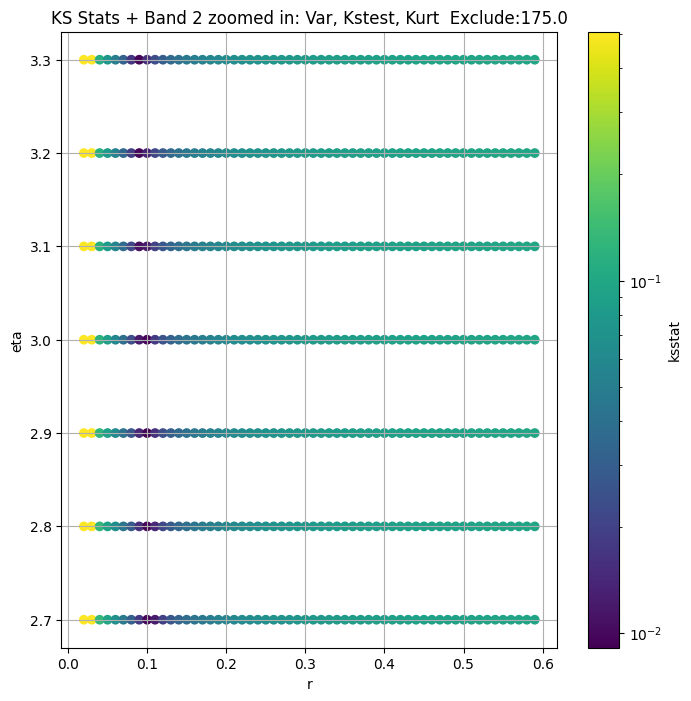

Band 5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 350.0 + 100 = 450, ksstat: 0.006915860160485288, var: 135.62118530273438


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 350.0 + 75 = 425, ksstat: 0.006577753650870877, var: 138.7271270751953


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 350.0 + 50 = 400, ksstat: 0.006222285871799849, var: 142.09561157226562


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 350.0 + 25 = 375, ksstat: 0.005866403910064655, var: 145.74127197265625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 350.0 + 0 = 350, ksstat: 0.00664940126190261, var: 149.7884521484375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 350.0 + -25 = 325, ksstat: 0.0070494742792820975, var: 154.18731689453125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 350.0 + -50 = 300, ksstat: 0.007632592838535207, var: 159.04696655273438


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 350.0 + -75 = 275, ksstat: 0.00831955008559715, var: 164.5061492919922


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 350.0 + -100 = 250, ksstat: 0.009116853611142034, var: 170.64572143554688
Number of samples: 100000, Without approximation : 117000.0


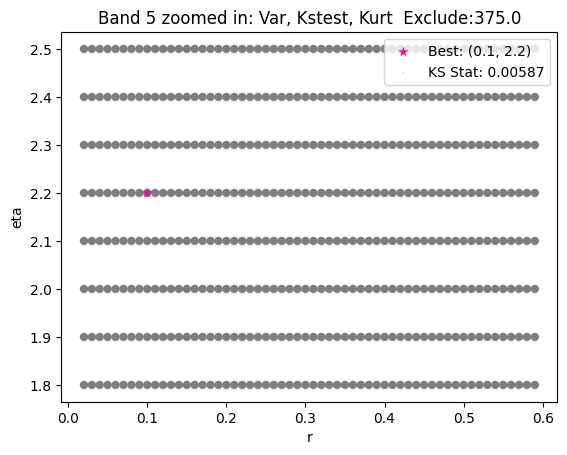

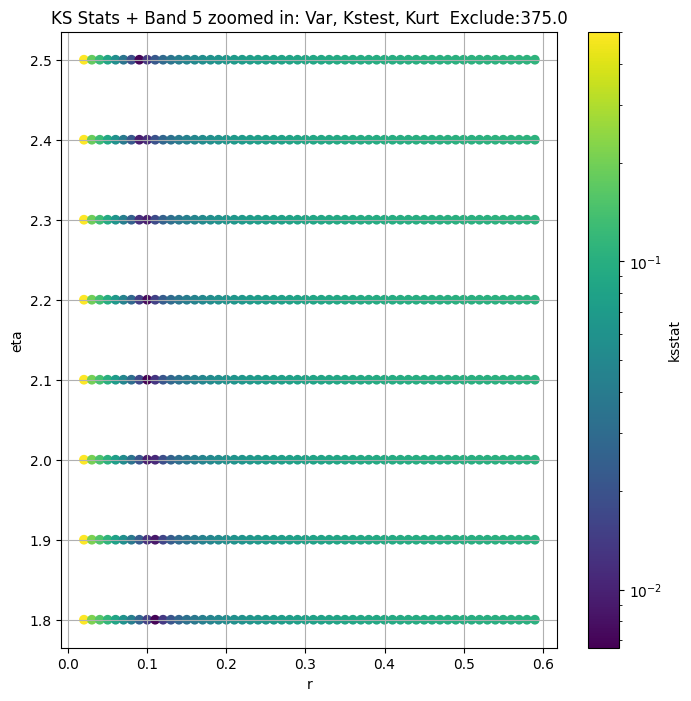

Band 8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 350.0 + 100 = 450, ksstat: 0.006805134950508607, var: 51.09601593017578


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 350.0 + 75 = 425, ksstat: 0.006530357639516593, var: 52.192344665527344


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 350.0 + 50 = 400, ksstat: 0.0062943759309325165, var: 53.362281799316406


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 350.0 + 25 = 375, ksstat: 0.005999306357456935, var: 54.63338088989258


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 350.0 + 0 = 350, ksstat: 0.005837380829851413, var: 56.017433166503906


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 350.0 + -25 = 325, ksstat: 0.005952484746762243, var: 57.53089904785156


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 350.0 + -50 = 300, ksstat: 0.0061399120515267525, var: 59.187294006347656


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 350.0 + -75 = 275, ksstat: 0.0069129151776836095, var: 61.00645446777344


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 350.0 + -100 = 250, ksstat: 0.007808329162141109, var: 63.071529388427734
Number of samples: 100000, Without approximation : 189000.0


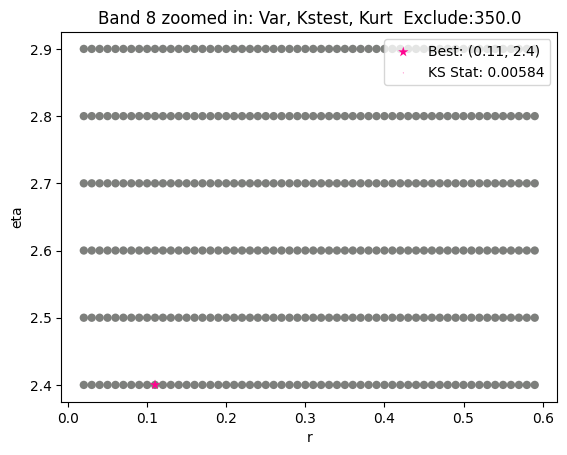

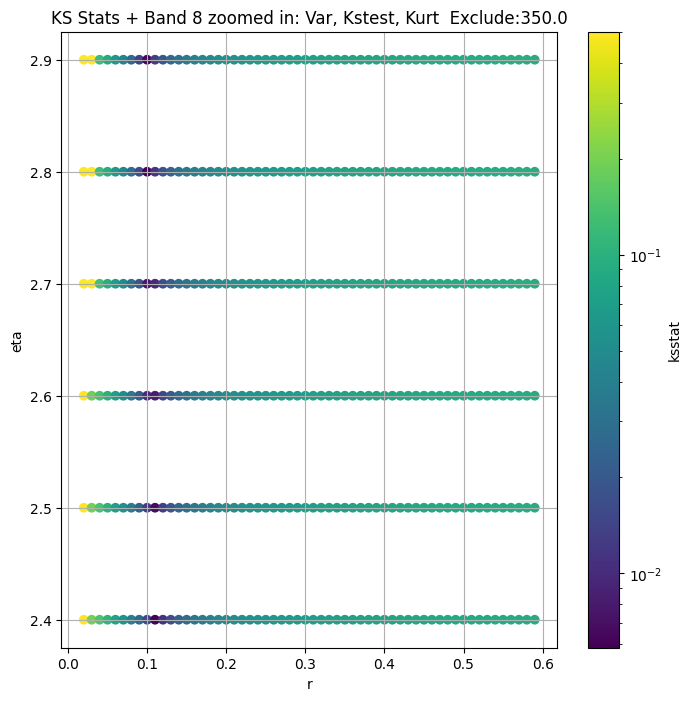

Band 11


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 11, 250.0 + 100 = 350, ksstat: 0.004979202743615296, var: 25.136089324951172


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 11, 250.0 + 75 = 325, ksstat: 0.0047290715748323775, var: 25.721996307373047


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 11, 250.0 + 50 = 300, ksstat: 0.004488959948444227, var: 26.36941146850586


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 11, 250.0 + 25 = 275, ksstat: 0.004211608545813705, var: 27.084148406982422


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 11, 250.0 + 0 = 250, ksstat: 0.003920136625429227, var: 27.890636444091797


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 11, 250.0 + -25 = 225, ksstat: 0.0036535293119467765, var: 28.80377960205078


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 11, 250.0 + -50 = 200, ksstat: 0.004863080154614119, var: 29.87462615966797


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 11, 250.0 + -75 = 175, ksstat: 0.0060972506227439105, var: 31.15608787536621


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 11, 250.0 + -100 = 150, ksstat: 0.006562851061493624, var: 32.68860626220703
Number of samples: 100000, Without approximation : 495000.0


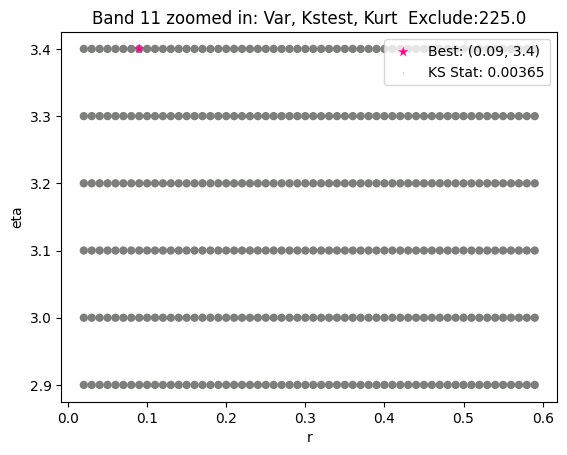

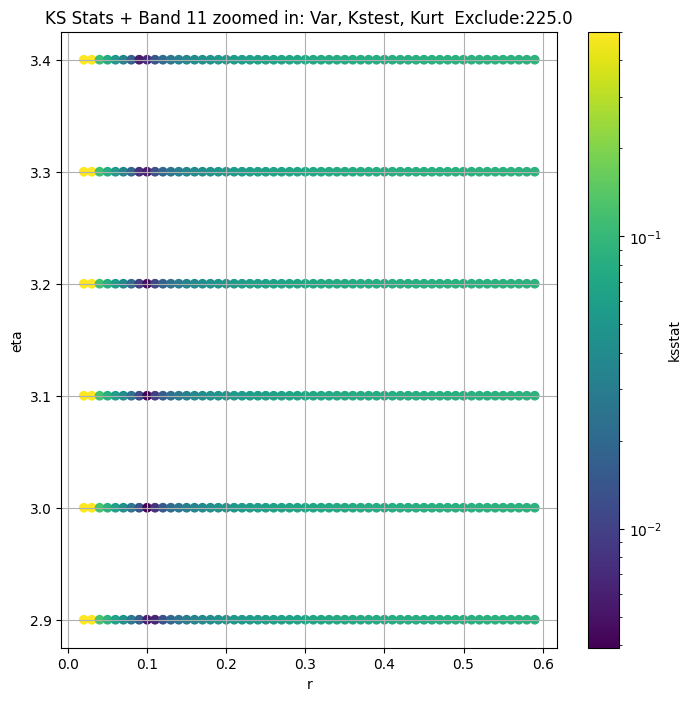

Band 14


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 200.0 + 100 = 300, ksstat: 0.003957724953607578, var: 11.345743179321289


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 200.0 + 75 = 275, ksstat: 0.0036020895400163955, var: 11.614717483520508


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 200.0 + 50 = 250, ksstat: 0.003253597561713728, var: 11.91956615447998


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 200.0 + 25 = 225, ksstat: 0.002976351183576975, var: 12.268824577331543


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 200.0 + 0 = 200, ksstat: 0.002749478770597169, var: 12.677200317382812


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 200.0 + -25 = 175, ksstat: 0.002513237154915471, var: 13.159292221069336


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 200.0 + -50 = 150, ksstat: 0.0035322426809855645, var: 13.743671417236328


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 200.0 + -75 = 125, ksstat: 0.0050369565614479805, var: 14.47221851348877


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 200.0 + -100 = 100, ksstat: 0.006484068495305917, var: 15.409375190734863
Number of samples: 100000, Without approximation : 1134000.0


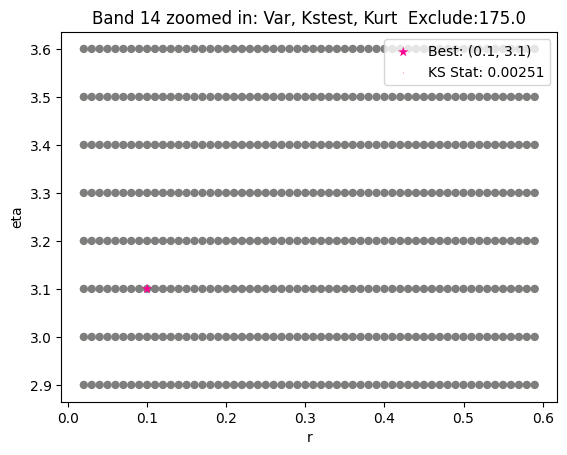

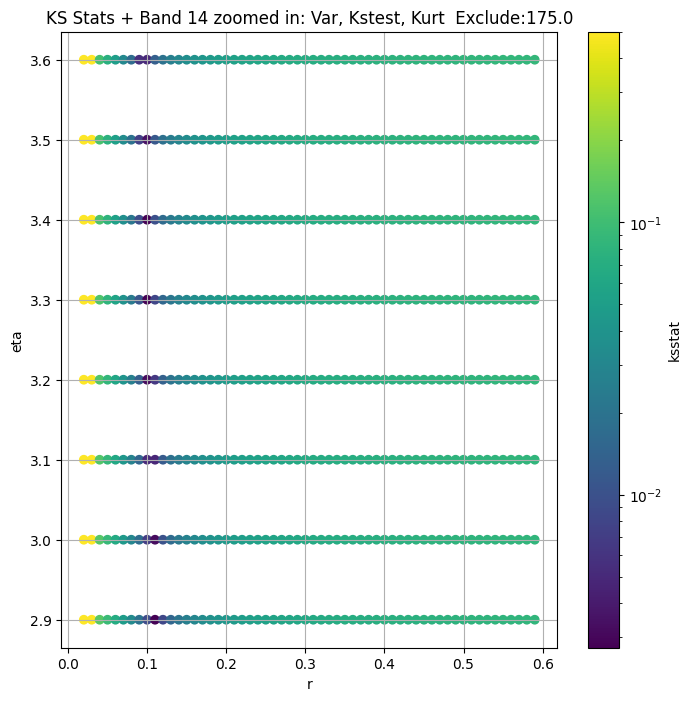

Band 17


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 150.0 + 100 = 250, ksstat: 0.00347509997302968, var: 5.857203960418701


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 150.0 + 75 = 225, ksstat: 0.0029407689153432386, var: 6.008770942687988


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 150.0 + 50 = 200, ksstat: 0.002566515146263694, var: 6.184279441833496


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 150.0 + 25 = 175, ksstat: 0.002308890160517397, var: 6.391366004943848


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 150.0 + 0 = 150, ksstat: 0.0020961049739335767, var: 6.640939235687256


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 150.0 + -25 = 125, ksstat: 0.0027220923169335304, var: 6.952570915222168


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 150.0 + -50 = 100, ksstat: 0.0038505023002656236, var: 7.355671405792236


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 150.0 + -75 = 75, ksstat: 0.005759117217265741, var: 7.902018070220947


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 150.0 + -100 = 50, ksstat: 0.00833161225393586, var: 8.710735321044922
Number of samples: 100000, Without approximation : 2574000.0


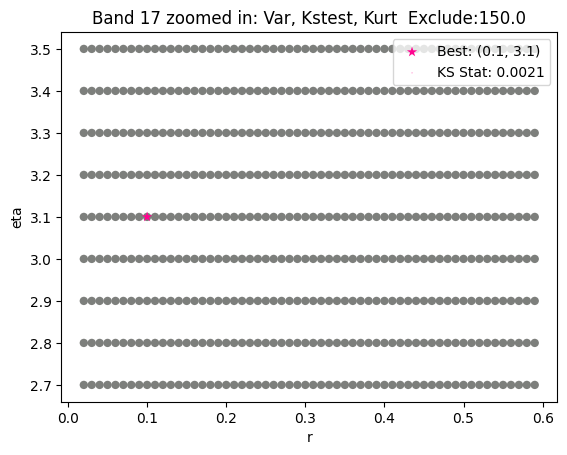

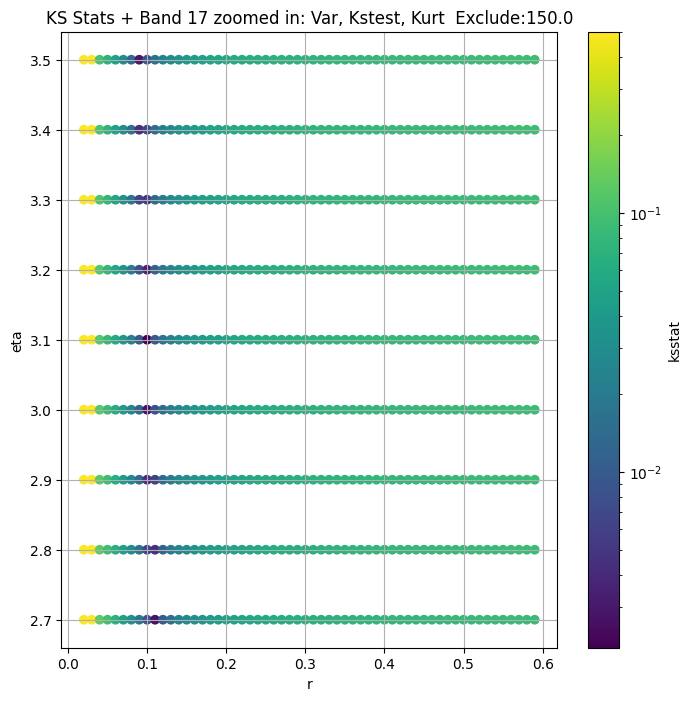

Band 20


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 200.0 + 100 = 300, ksstat: 0.005254390979024692, var: 3.1930508613586426


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 200.0 + 75 = 275, ksstat: 0.004706522024259242, var: 3.265465259552002


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 200.0 + 50 = 250, ksstat: 0.004216640584625904, var: 3.3464677333831787


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 200.0 + 25 = 225, ksstat: 0.0035887096814523622, var: 3.4383606910705566


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 200.0 + 0 = 200, ksstat: 0.003041734629836158, var: 3.544424295425415


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 200.0 + -25 = 175, ksstat: 0.0035887323865207987, var: 3.6693546772003174


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 200.0 + -50 = 150, ksstat: 0.0038728410460991958, var: 3.819817066192627


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 200.0 + -75 = 125, ksstat: 0.004682479237192283, var: 4.006567478179932


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 200.0 + -100 = 100, ksstat: 0.005801212034724945, var: 4.248332500457764
Number of samples: 100000, Without approximation : 5967000.0


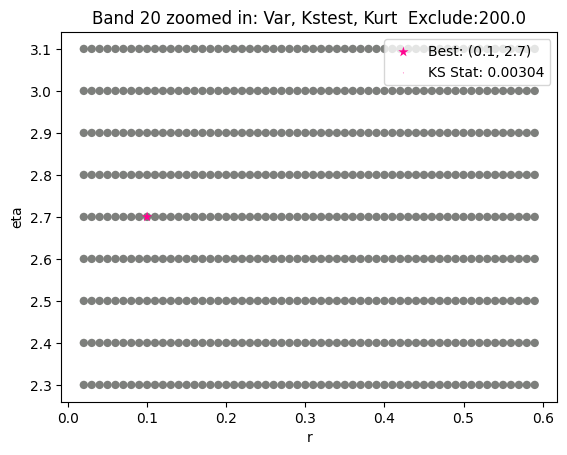

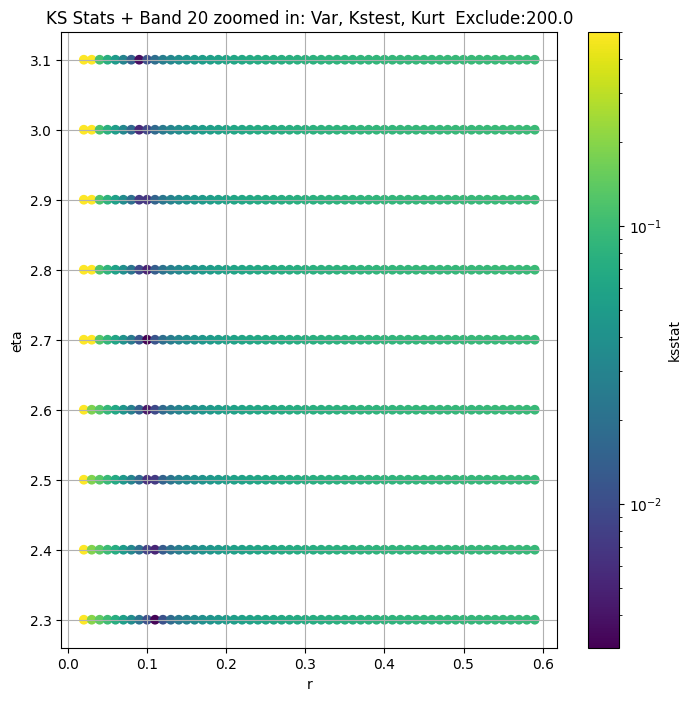

Band 23


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 23, 200.0 + 100 = 300, ksstat: 0.006050170668275401, var: 1.3037697076797485


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 23, 200.0 + 75 = 275, ksstat: 0.0055745077541202726, var: 1.3319138288497925


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 23, 200.0 + 50 = 250, ksstat: 0.005080586959045785, var: 1.363016963005066


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 23, 200.0 + 25 = 225, ksstat: 0.004701993800382054, var: 1.3977882862091064


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 23, 200.0 + 0 = 200, ksstat: 0.004685369978306209, var: 1.4372928142547607


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 23, 200.0 + -25 = 175, ksstat: 0.005037373722958649, var: 1.4831864833831787


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 23, 200.0 + -50 = 150, ksstat: 0.005750682531199869, var: 1.5380120277404785


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 23, 200.0 + -75 = 125, ksstat: 0.006061893473364721, var: 1.6056556701660156


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 23, 200.0 + -100 = 100, ksstat: 0.007553031191249726, var: 1.692908763885498
Number of samples: 100000, Without approximation : 13887000.0


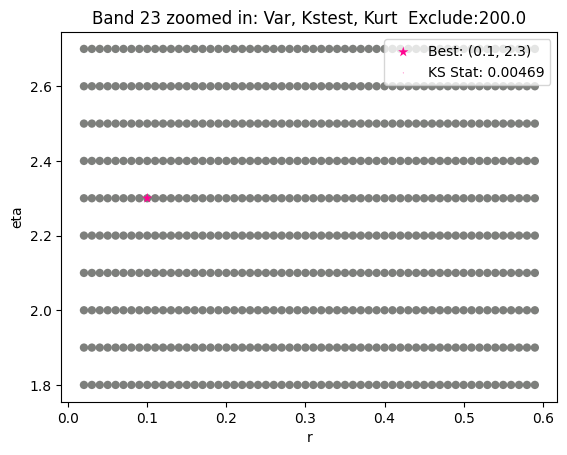

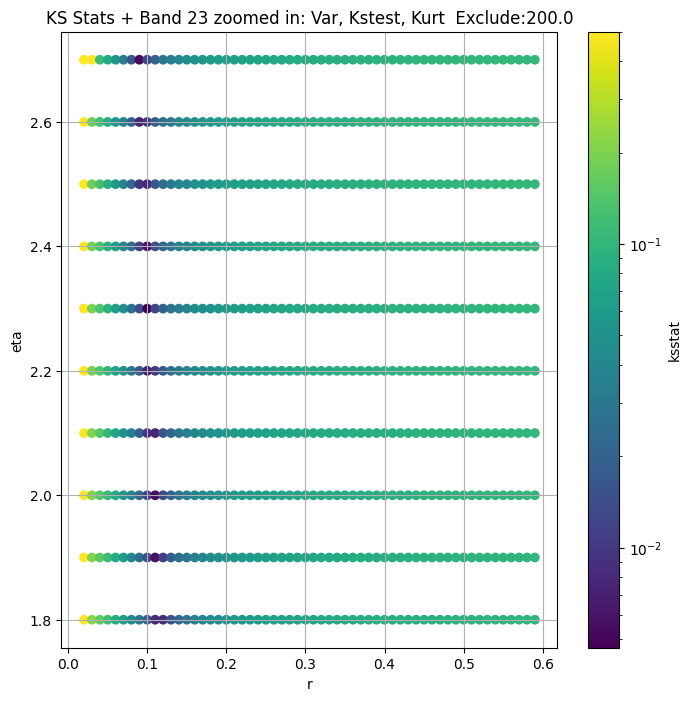

Band 26


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 200.0 + 100 = 300, ksstat: 0.006567255081949441, var: 0.3538875877857208


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 200.0 + 75 = 275, ksstat: 0.0061446820074050335, var: 0.36256134510040283


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 200.0 + 50 = 250, ksstat: 0.005743573875616748, var: 0.37214046716690063


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 200.0 + 25 = 225, ksstat: 0.005446194601746779, var: 0.3828568756580353


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 200.0 + 0 = 200, ksstat: 0.005690345016257092, var: 0.39502477645874023


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 200.0 + -25 = 175, ksstat: 0.00566712504782807, var: 0.40911054611206055


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 200.0 + -50 = 150, ksstat: 0.006739336216562863, var: 0.42583170533180237


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 200.0 + -75 = 125, ksstat: 0.007499424220032358, var: 0.4463699758052826


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 200.0 + -100 = 100, ksstat: 0.008058697624210298, var: 0.4726250469684601
Number of samples: 100000, Without approximation : 31968000.0


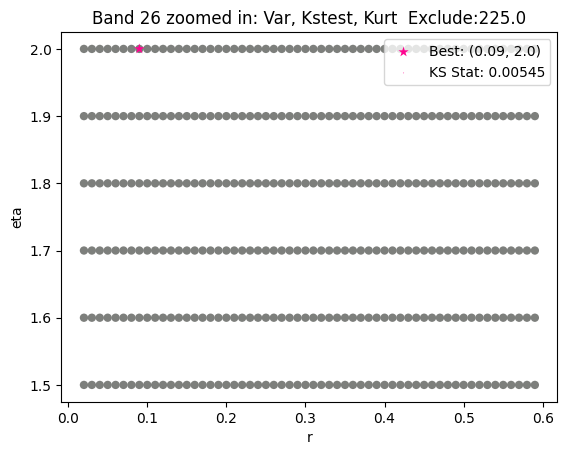

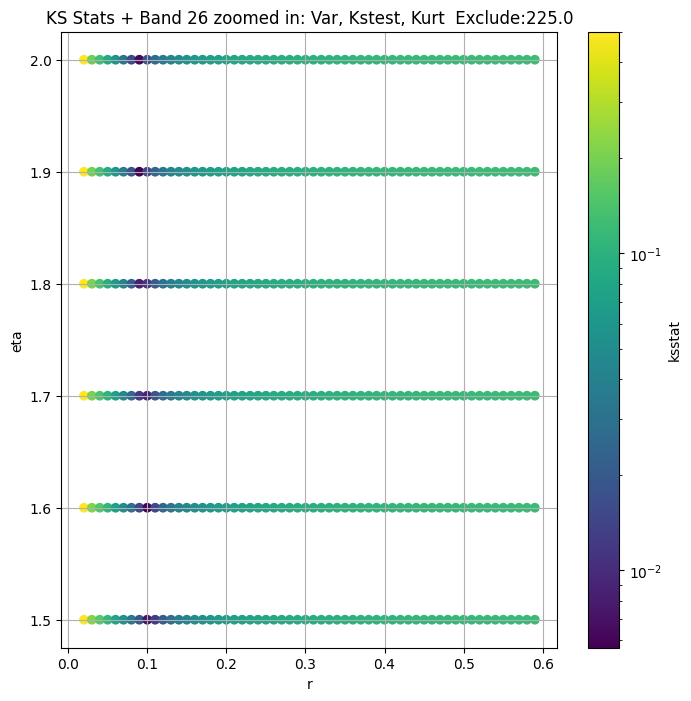

Band 29


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 29, 300.0 + 100 = 400, ksstat: 0.010078477418315135, var: 0.0384080708026886


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 29, 300.0 + 75 = 375, ksstat: 0.009917478448829065, var: 0.03922465816140175


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 29, 300.0 + 50 = 350, ksstat: 0.00934598893838312, var: 0.040098343044519424


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 29, 300.0 + 25 = 325, ksstat: 0.009270567453089434, var: 0.041037626564502716


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 29, 300.0 + 0 = 300, ksstat: 0.008782651588489565, var: 0.042054906487464905


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 29, 300.0 + -25 = 275, ksstat: 0.00918116093265664, var: 0.043165870010852814


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 29, 300.0 + -50 = 250, ksstat: 0.00918767613546767, var: 0.044391289353370667


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 29, 300.0 + -75 = 225, ksstat: 0.009942785417814543, var: 0.04575897380709648


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 29, 300.0 + -100 = 200, ksstat: 0.010122979736838067, var: 0.047309160232543945
Number of samples: 100000, Without approximation : 73701000.0


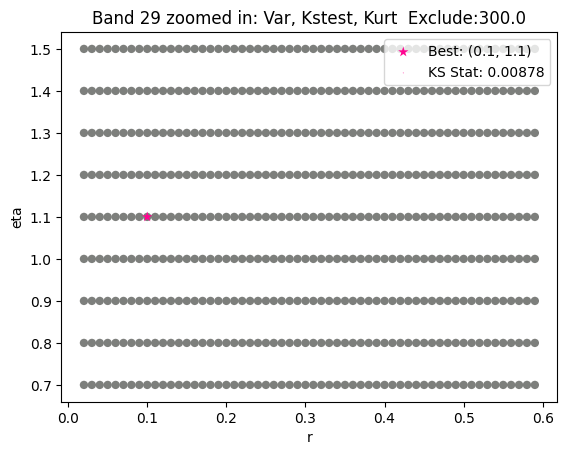

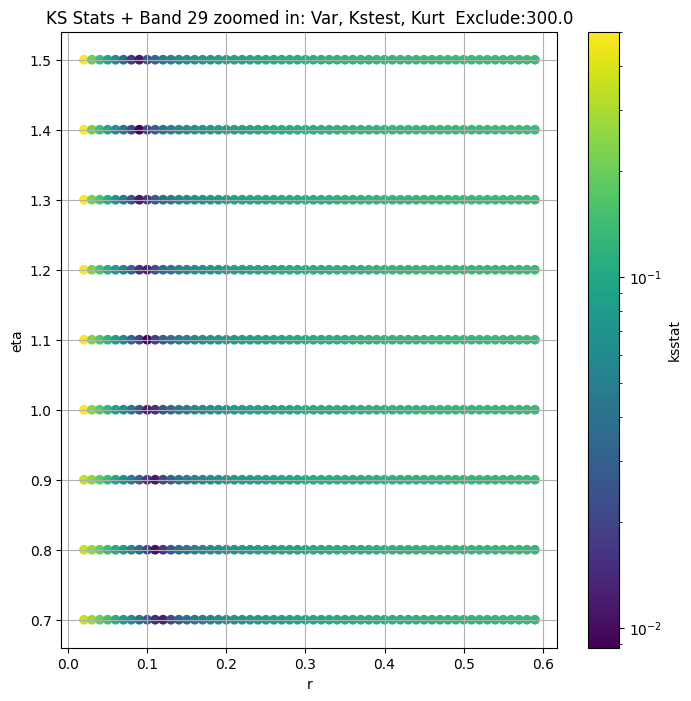

Band 32


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 32, 500.0 + 100 = 600, ksstat: 0.011745210803223625, var: 0.0035311405081301928


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 32, 500.0 + 75 = 575, ksstat: 0.011383609723033244, var: 0.0035881397780030966


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 32, 500.0 + 50 = 550, ksstat: 0.01118317377932571, var: 0.0036475262604653835


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 32, 500.0 + 25 = 525, ksstat: 0.010931622154172906, var: 0.003709514392539859


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 32, 500.0 + 0 = 500, ksstat: 0.010636578808763342, var: 0.003774344688281417


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 32, 500.0 + -25 = 475, ksstat: 0.010256113249131928, var: 0.0038423098158091307


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 32, 500.0 + -50 = 450, ksstat: 0.011143593392501538, var: 0.00391369266435504


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 32, 500.0 + -75 = 425, ksstat: 0.010678968585406512, var: 0.003988925833255053


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 32, 500.0 + -100 = 400, ksstat: 0.011829137335987838, var: 0.004068478476256132
Number of samples: 100000, Without approximation : 59634000.0


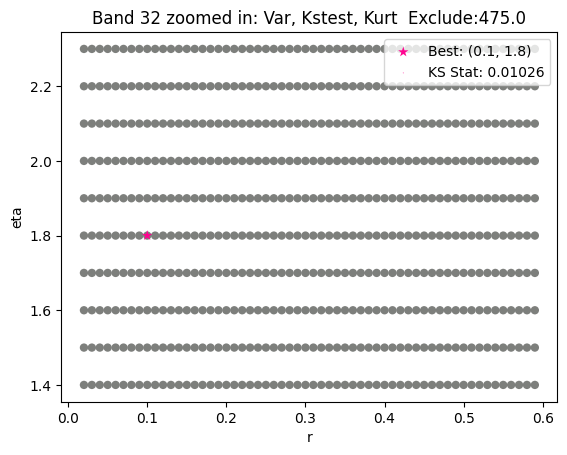

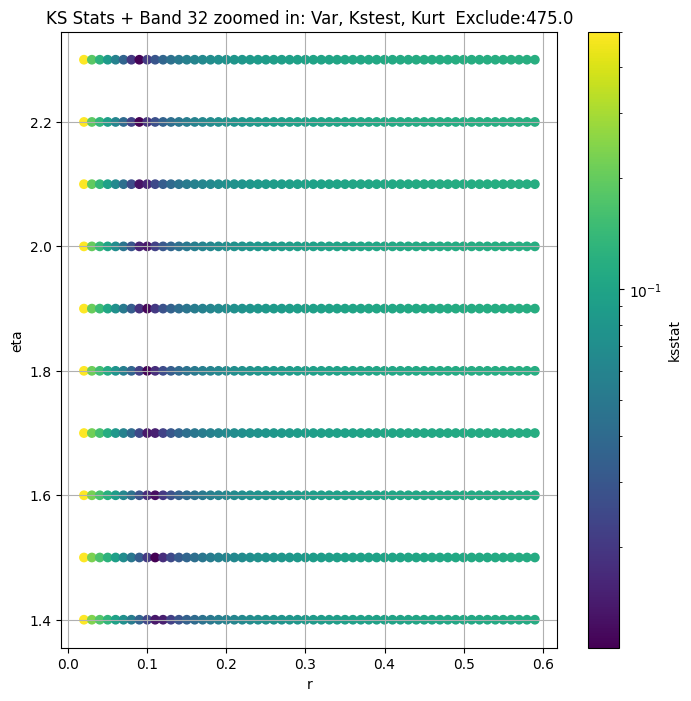

obs_var   var_lower    var_upper     obs_kurt  kurt_lower  \
band                                                                  
2     1021.589840  632.272500  1625.946700    360.00027  103.517940   
5      613.385000  337.520480  1441.568100   1149.93900   99.624860   
8      207.881040  118.970184   419.744200    744.87524   90.633835   
11     118.822140   50.023308   488.236450   5619.66460   83.865580   
14      40.410416   20.525957   130.472370   2531.13770   77.299590   
17      25.864876    9.595861   151.859590  11999.47100   68.112076   
20      13.953182    5.587813    65.674805   7428.83840   72.217384   
23       6.573230    2.182701    44.126280  17039.29100   63.021640   
26       3.953361    0.617809    40.390670  33131.47300   70.198720   
29       0.418982    0.077271     3.418306  27537.83200   85.778534   
32       0.013868    0.008013     0.031387   1045.78520   83.576560   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2       707.7830        45000.0             0.009088        0.1          2.9   
5      3055.2026       117000.0             0.006649        0.1          2.1   
8      2225.1548       189000.0             0.005866        0.1          2.8   
11     6158.5415       495000.0             0.003920        0.1          3.0   
14     4791.7000      1134000.0             0.002749        0.1          3.3   
17     7838.7065      2574000.0             0.002096        0.1          3.1   
20     6734.7490      5967000.0             0.003042        0.1          2.7   
23     8338.4800     13887000.0             0.004685        0.1          2.3   
26     9346.5490     31968000.0             0.005839        0.1          1.6   
29     9120.4880     73701000.0             0.008783        0.1          1.1   
32     2666.2980     59634000.0             0.010923        0.1          1.8   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      3.739454e-15                   200.0          276.910248   
5      1.293895e-14                   350.0          145.741272   
8      9.757825e-16                   350.0           56.017433   
11     3.211735e-16                   250.0           28.803780   
14     8.089977e-17                   200.0           13.159292   
17     6.256921e-17                   150.0            6.640939   
20     7.644157e-17                   200.0            3.544424   
23     7.649175e-17                   200.0            1.437293   
26     1.284220e-16                   200.0            0.382857   
29     6.312912e-17                   300.0            0.042055   
32     7.068627e-19                   500.0            0.003842   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.006398          0.008746    0.09       3.2   
5                    0.003969          0.005866    0.10       2.2   
8                    0.003123          0.005837    0.11       2.4   
11                   0.001930          0.003654    0.09       3.4   
14                   0.001275          0.002513    0.10       3.1   
17                   0.000846          0.002096    0.10       3.1   
20                   0.000556          0.003042    0.10       2.7   
23                   0.000364          0.004685    0.10       2.3   
26                   0.000240          0.005446    0.09       2.0   
29                   0.000158          0.008783    0.10       1.1   
32                   0.000176          0.010256    0.10       1.8   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     8.254394e-18                175.0        25312  
5     9.852536e-15                375.0        55528  
8     1.747615e-13                350.0        53155  


In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

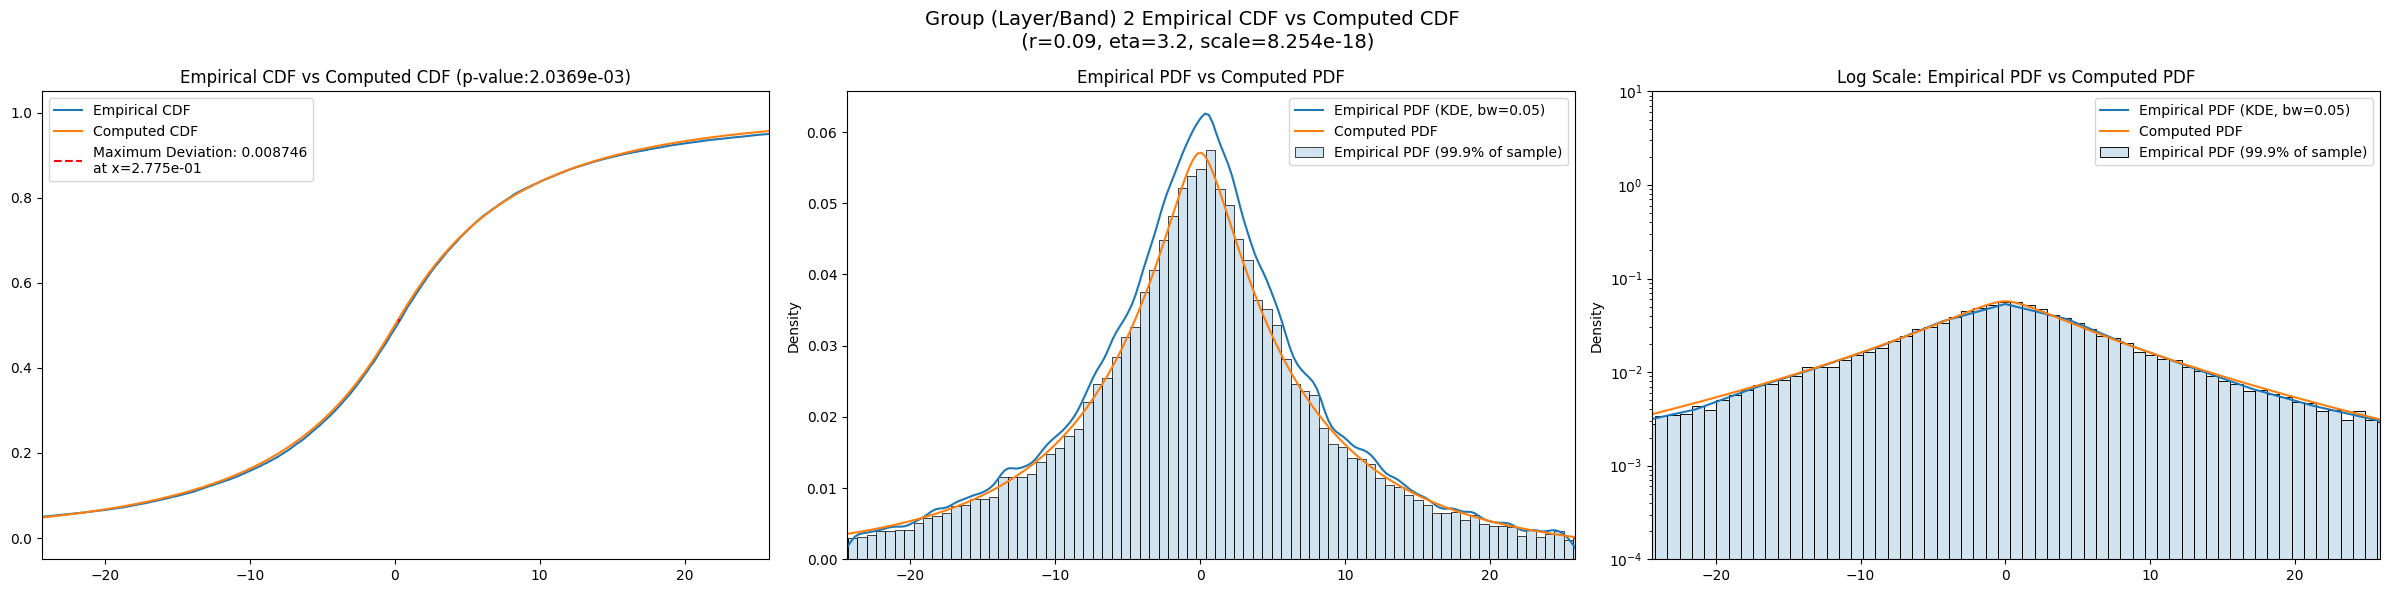

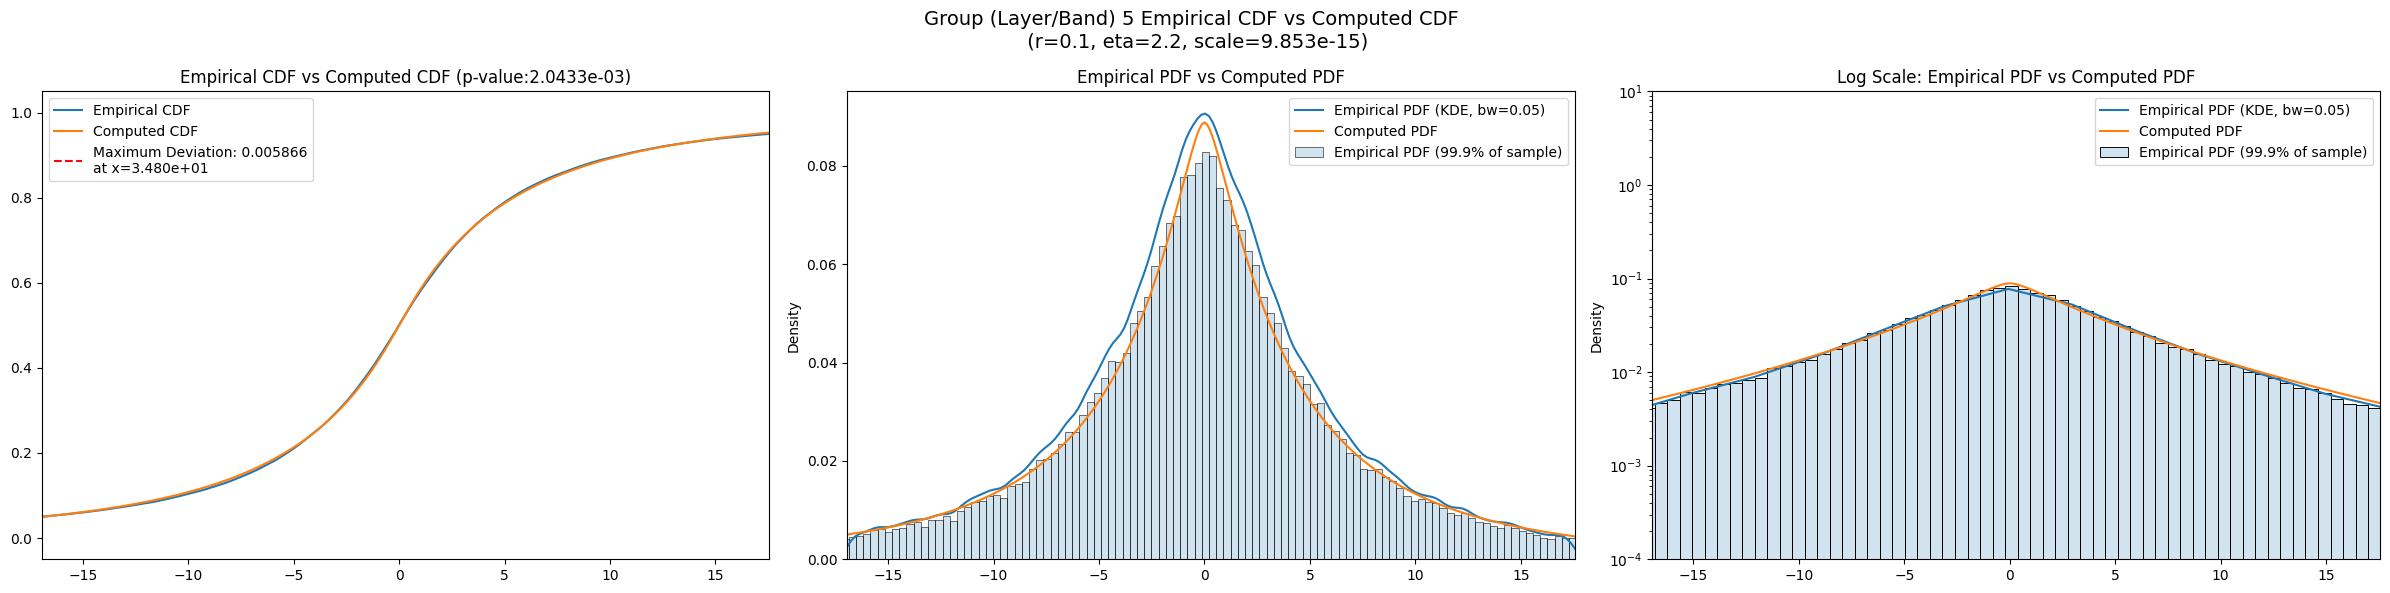

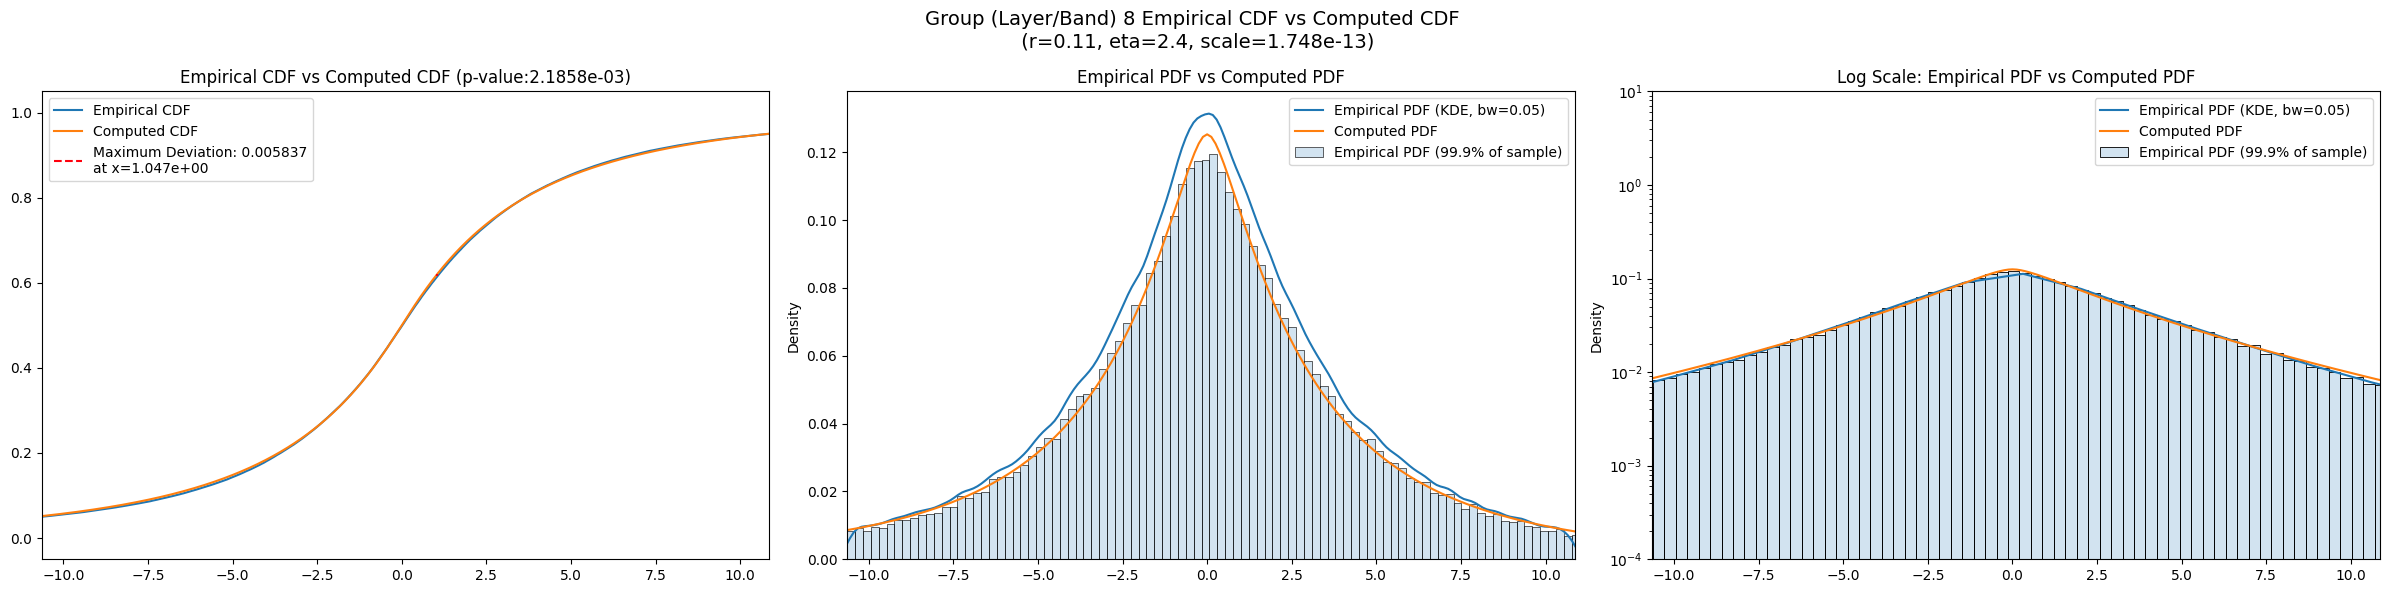

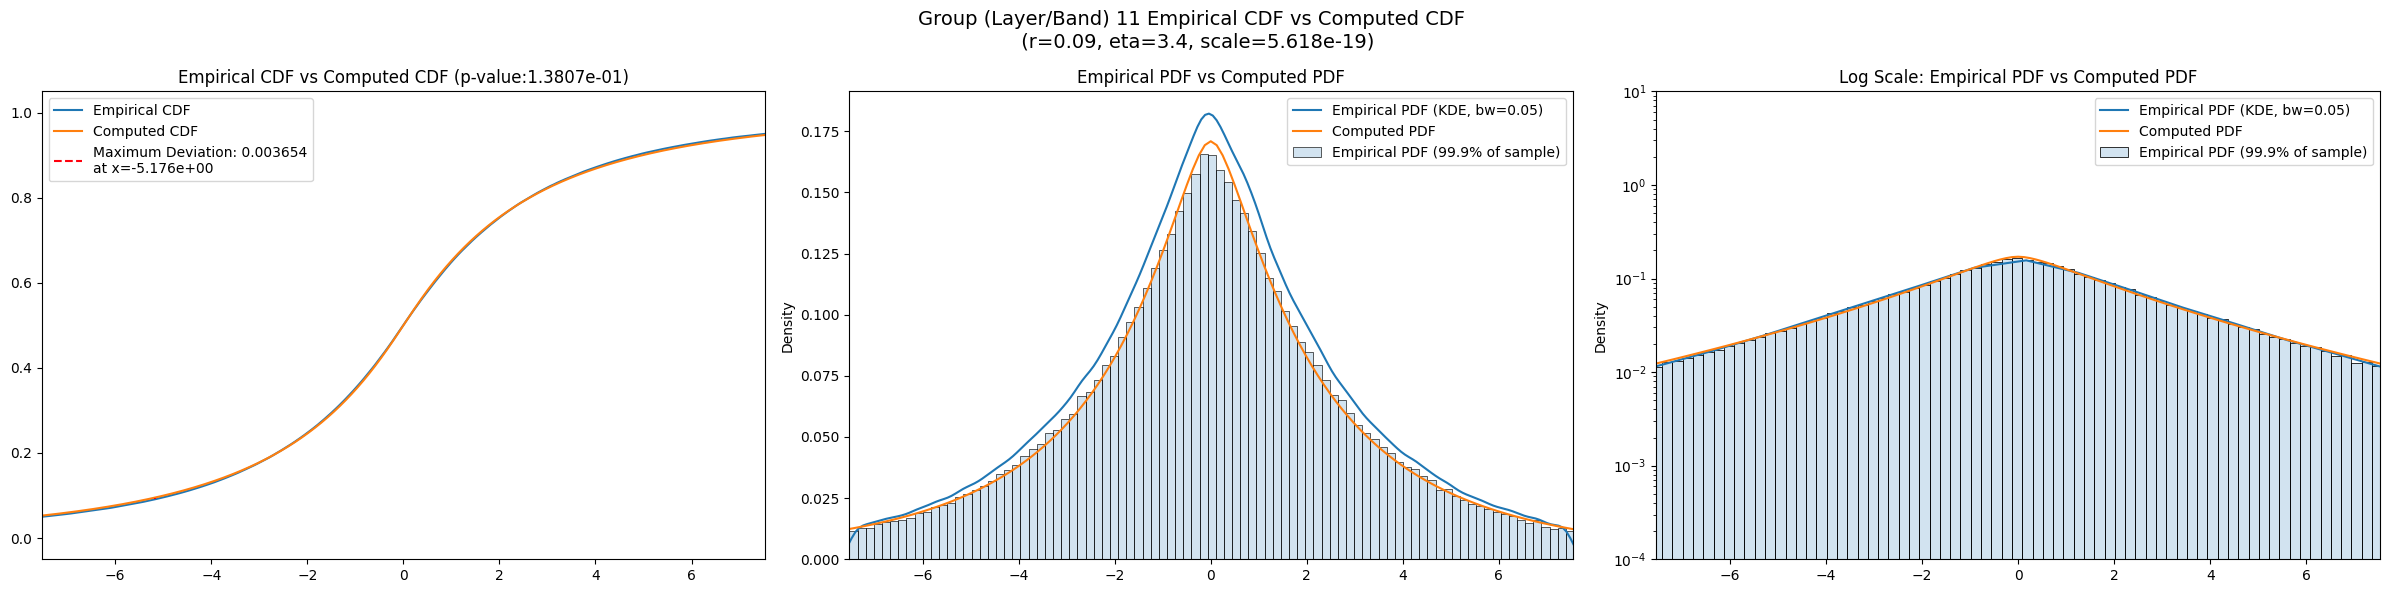

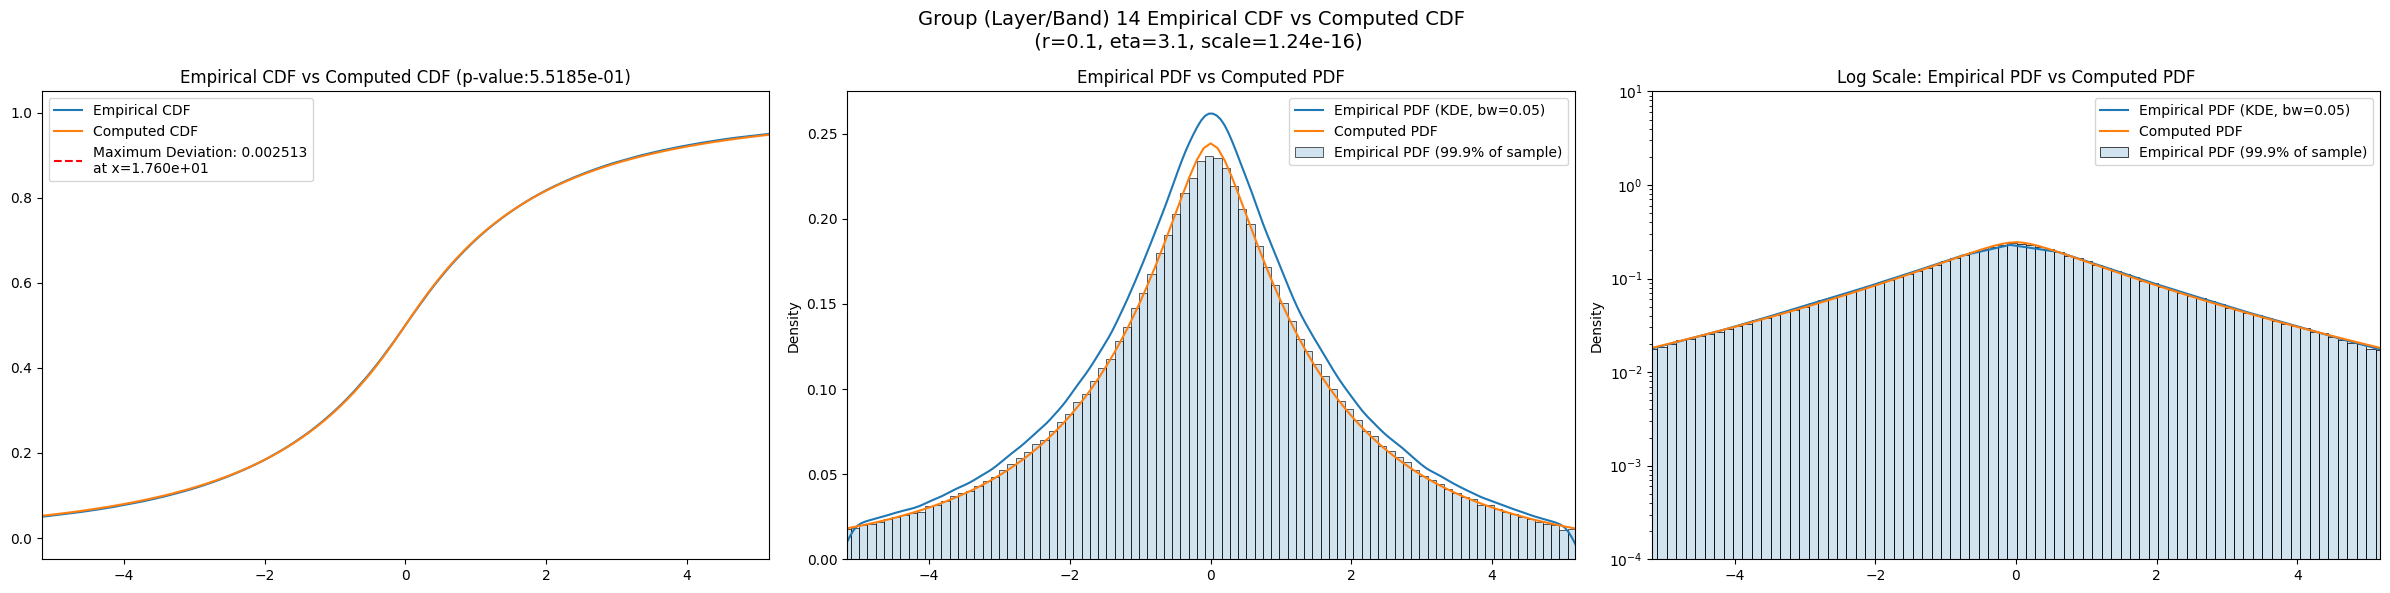

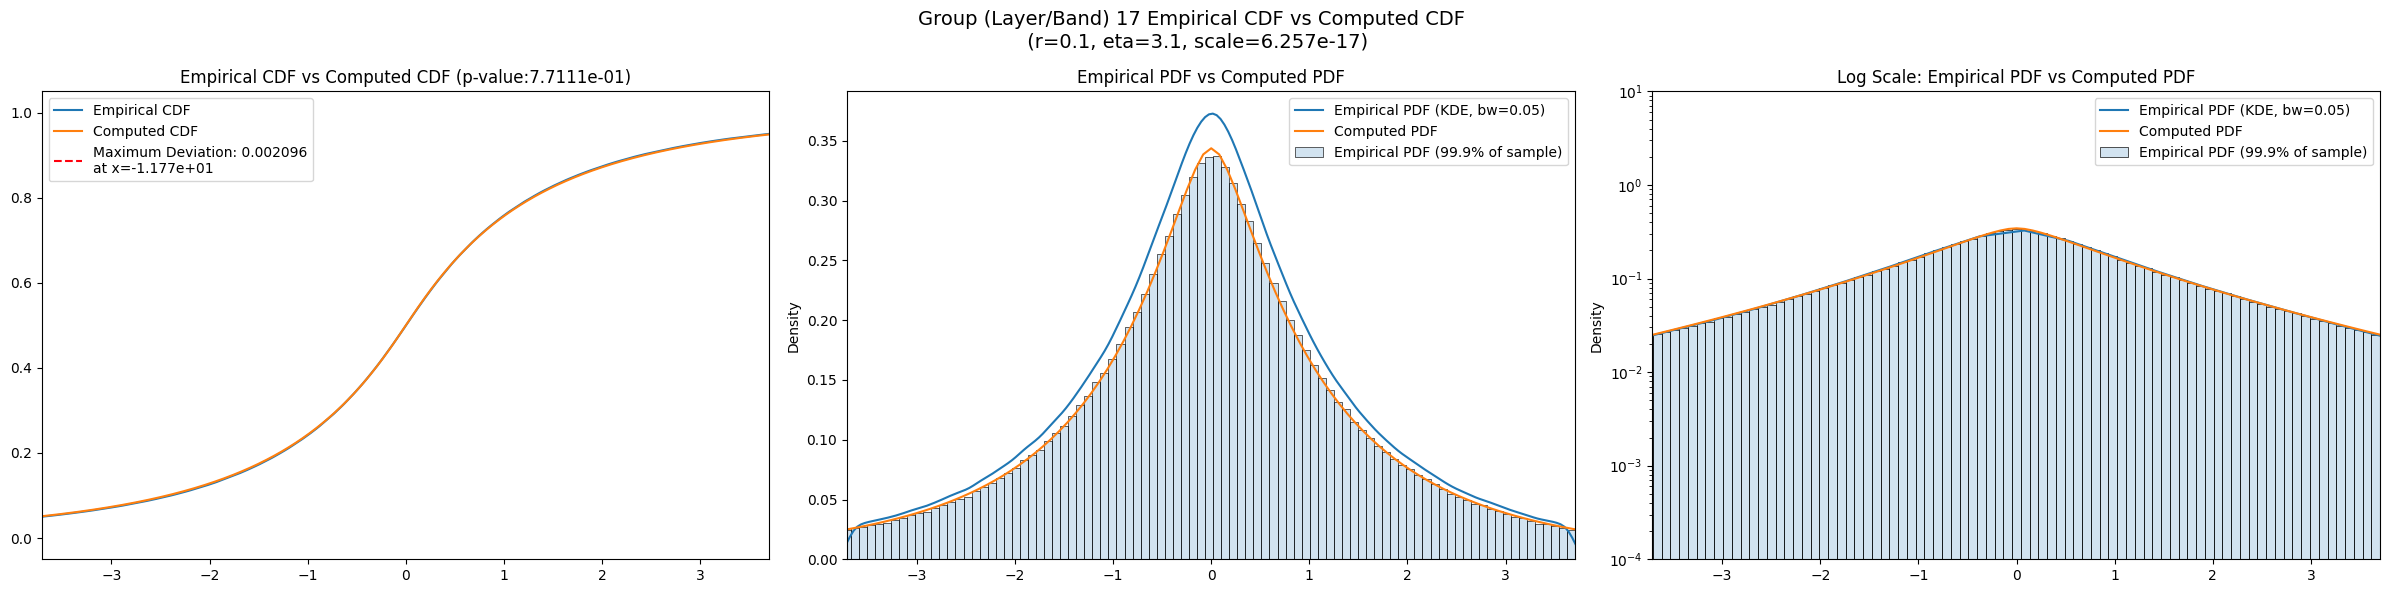

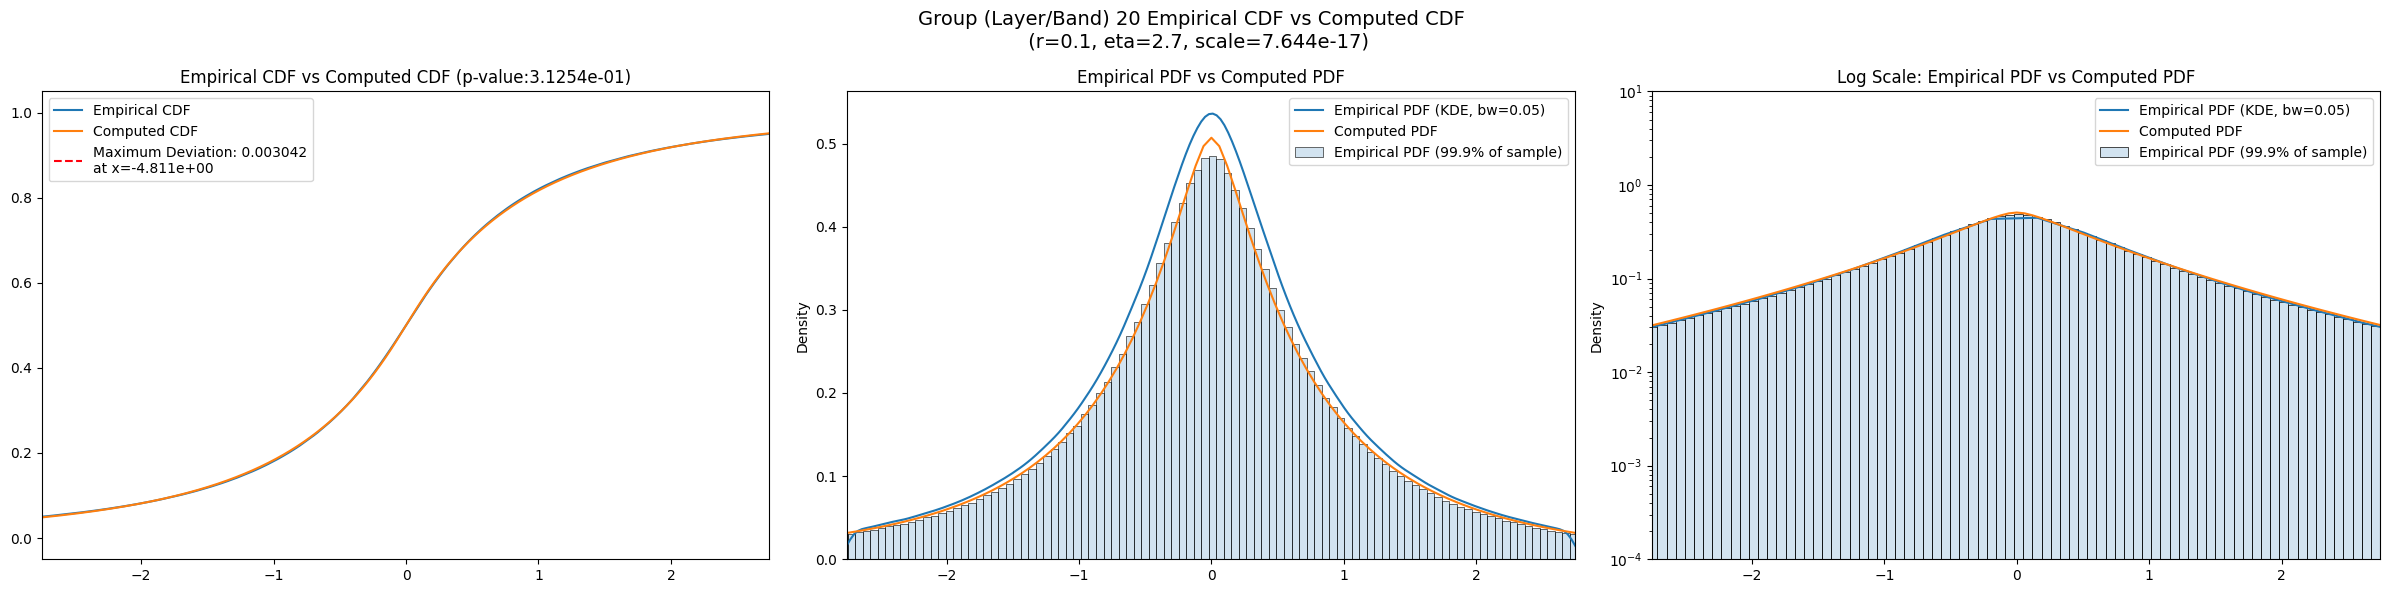

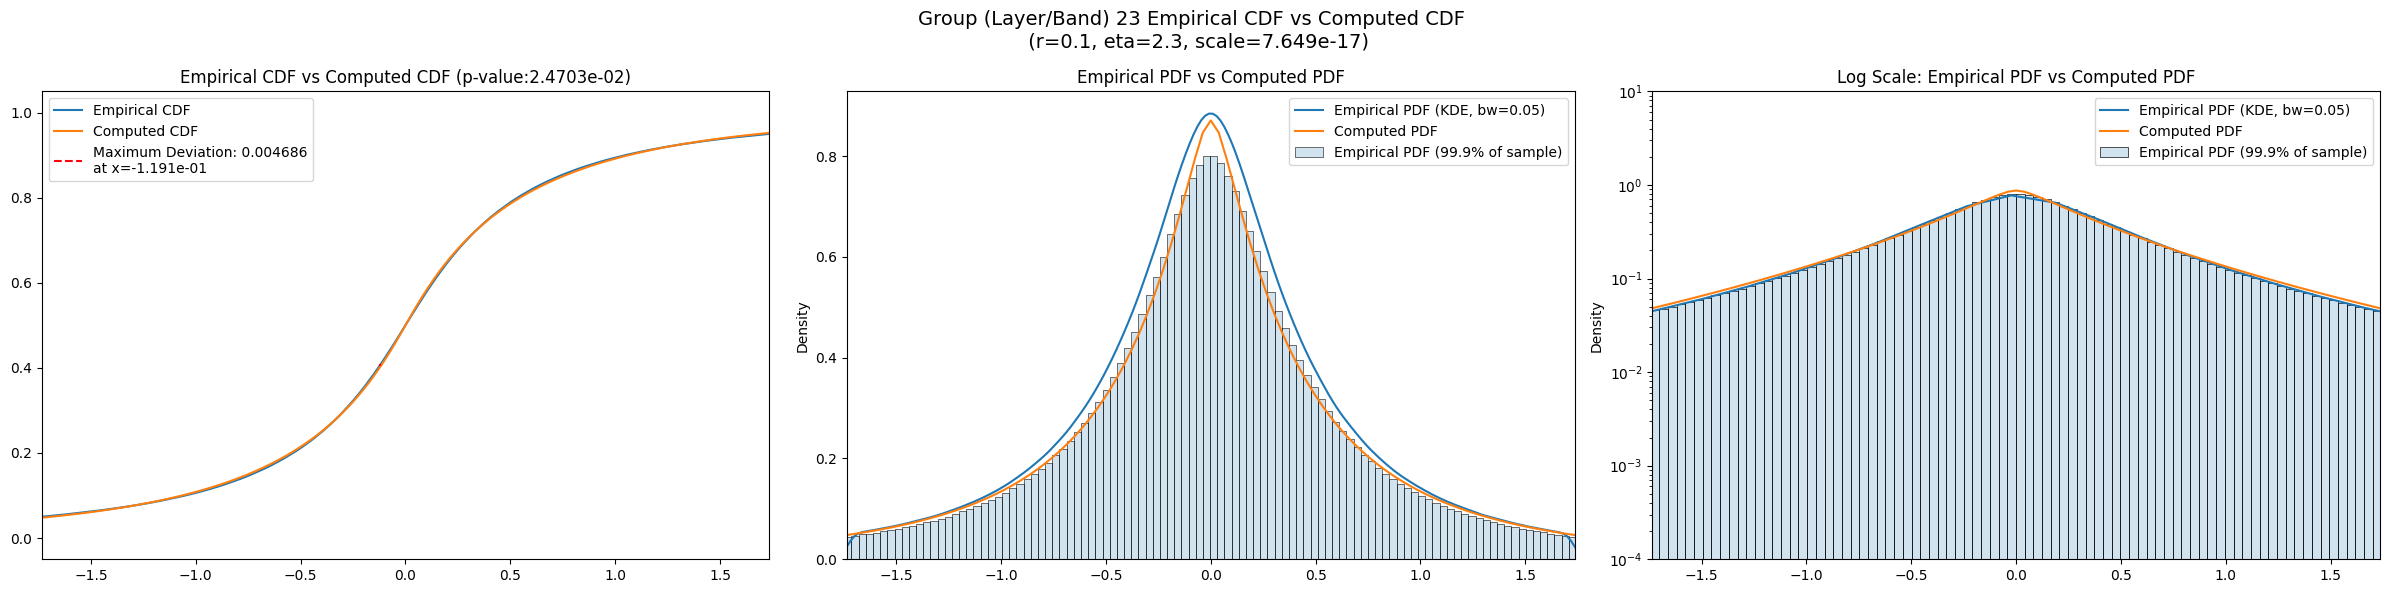

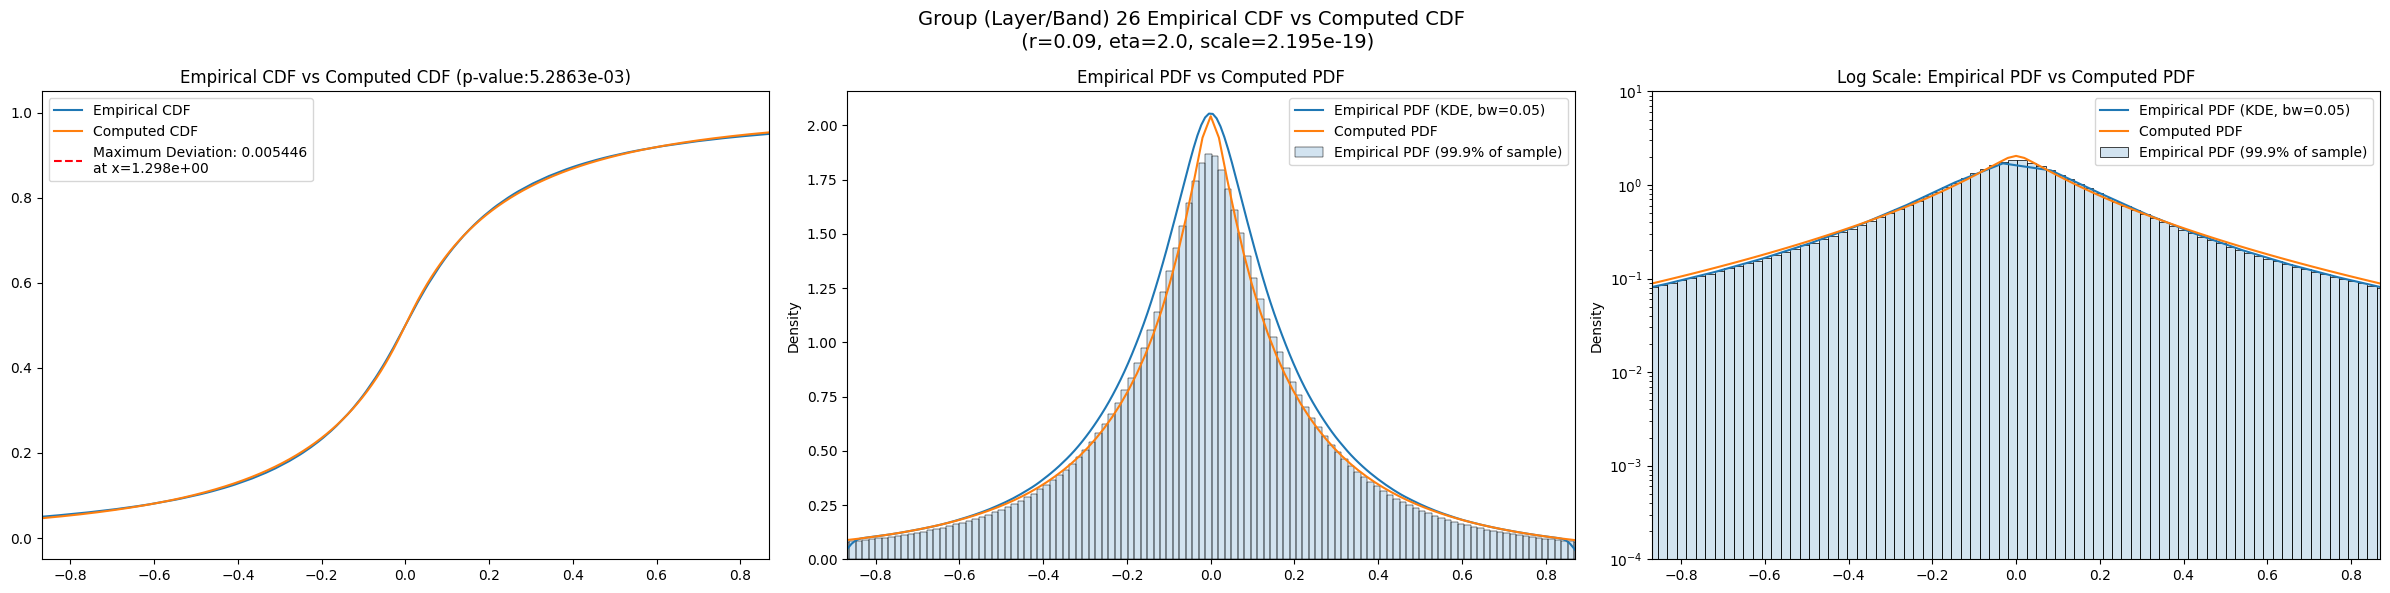

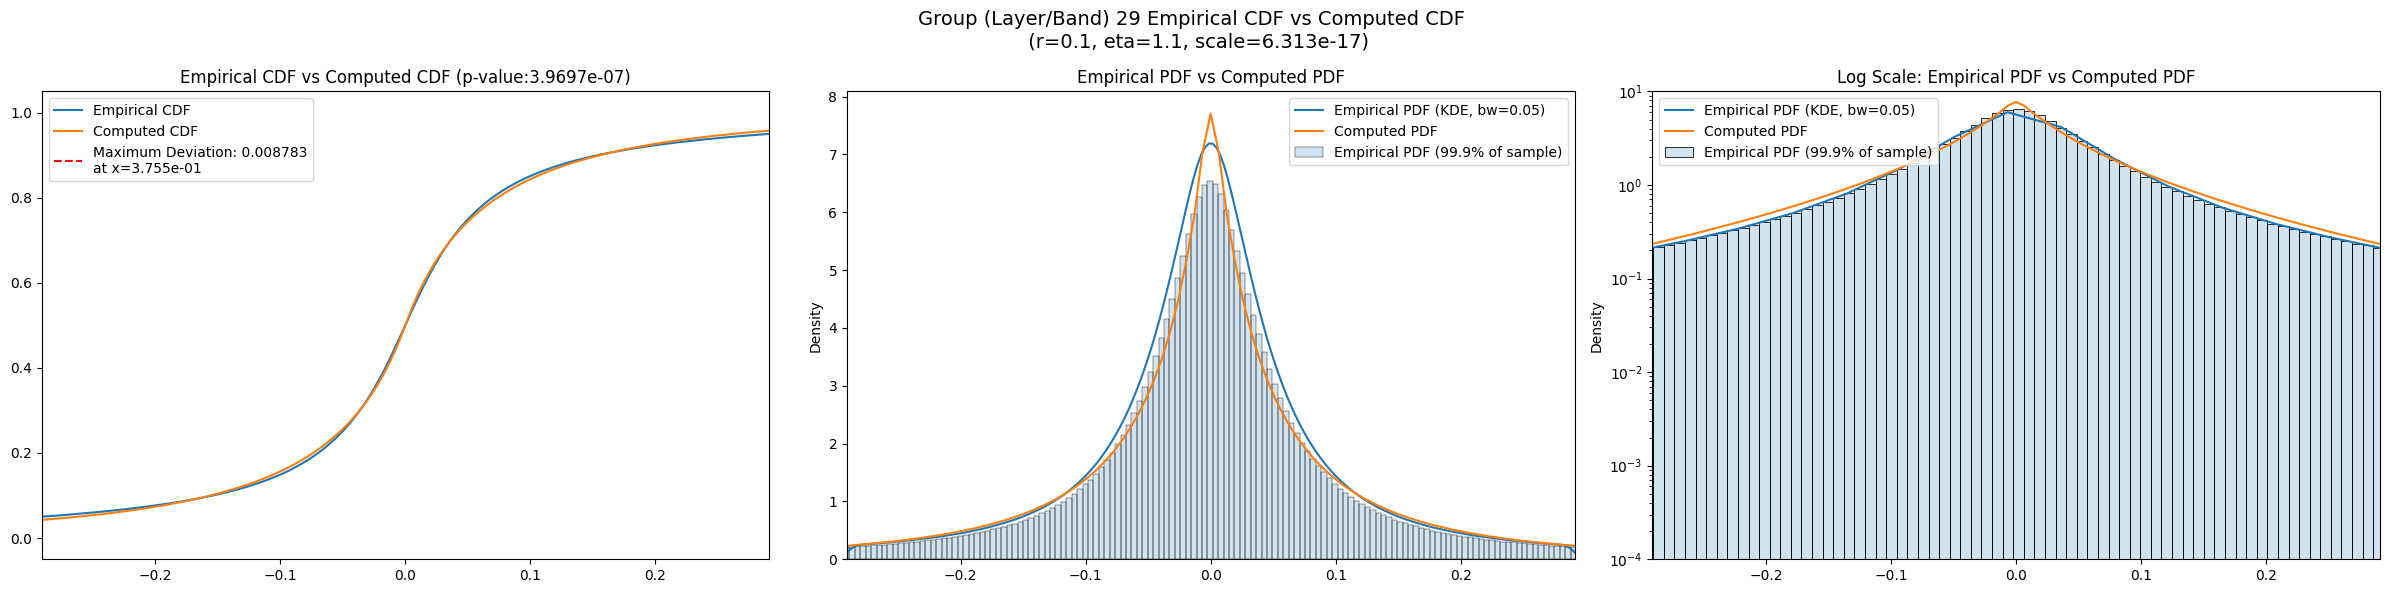

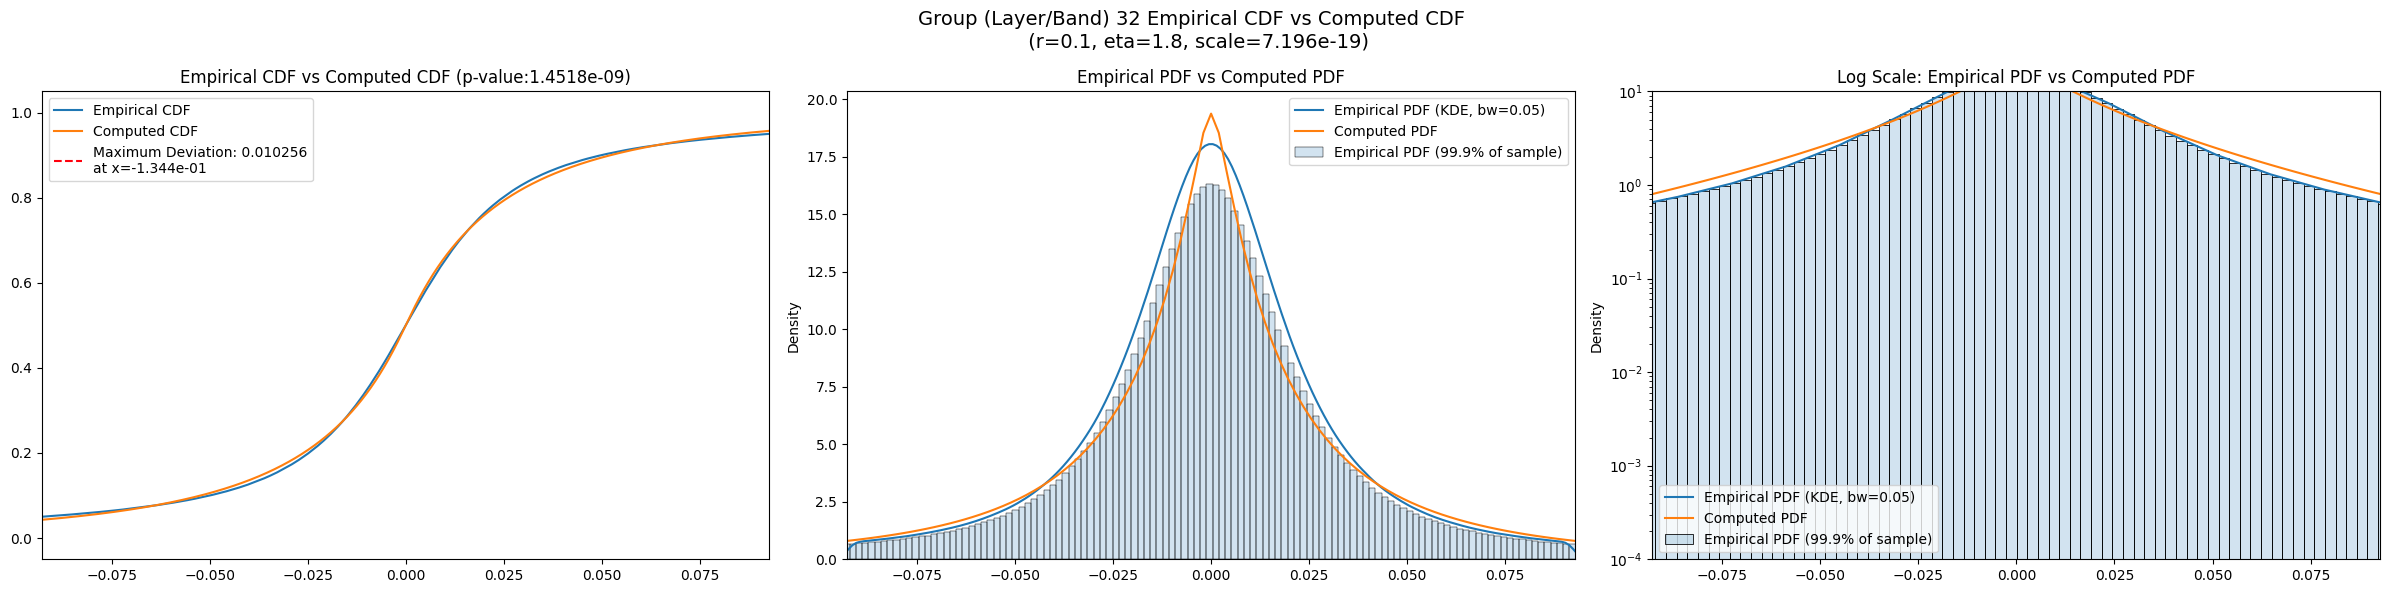

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

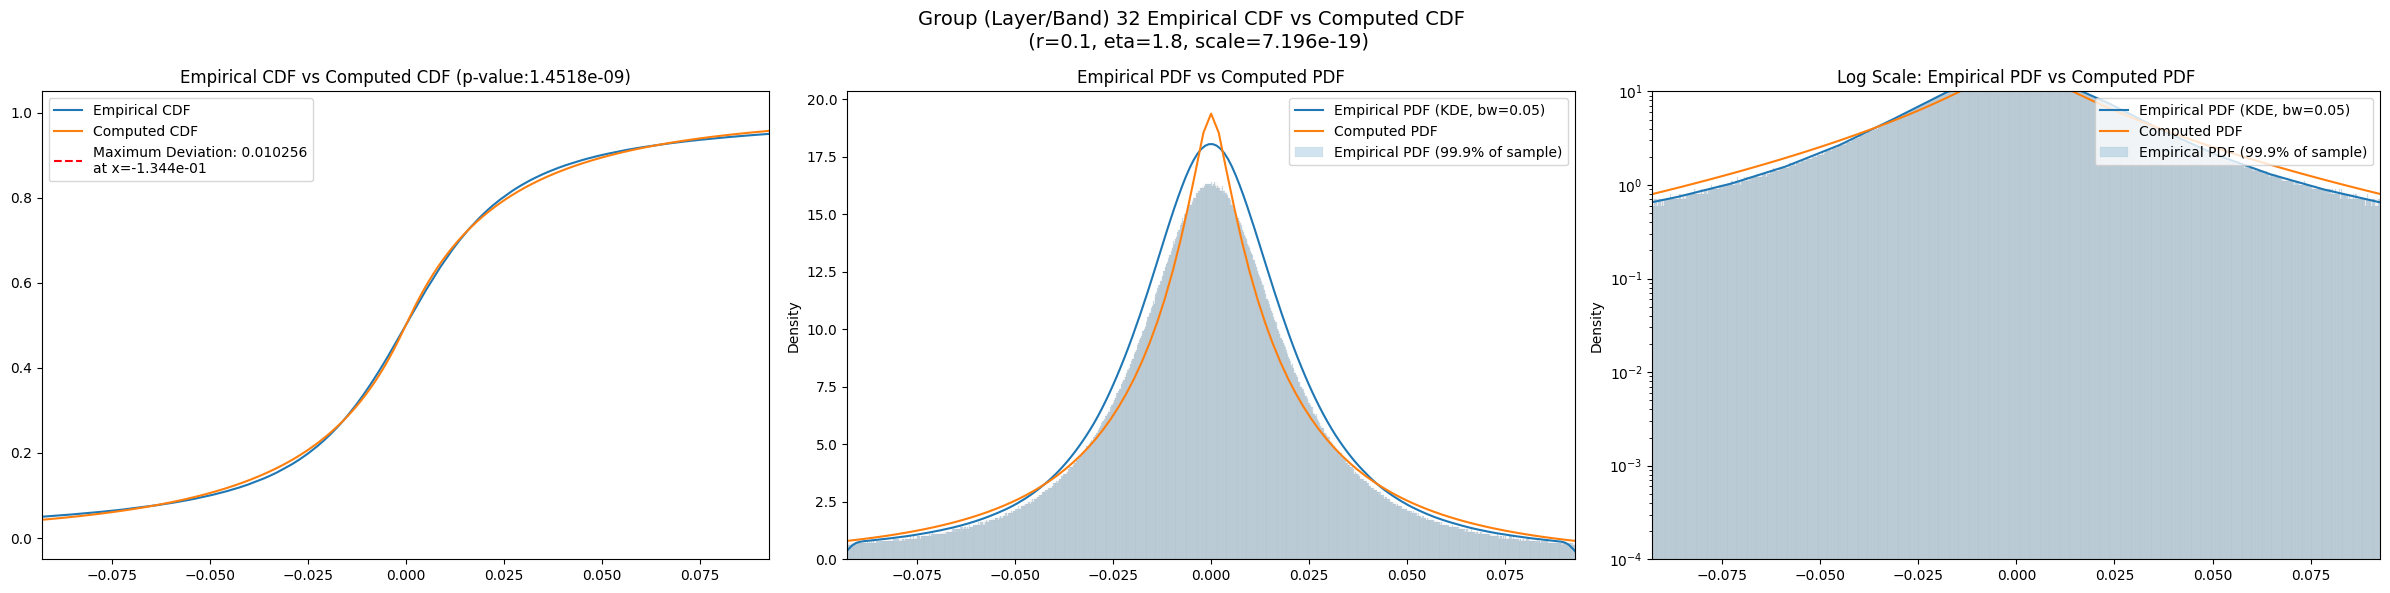

/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_58242/1793147435.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)


In [16]:
for group in GROUPS[-1:]:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group,
                    binwidth=0.0001)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var   var_lower    var_upper     obs_kurt  kurt_lower  \
band                                                                  
2     1021.589840  632.272500  1625.946700    360.00027  103.517940   
5      613.385000  337.520480  1441.568100   1149.93900   99.624860   
8      207.881040  118.970184   419.744200    744.87524   90.633835   
11     118.822140   50.023308   488.236450   5619.66460   83.865580   
14      40.410416   20.525957   130.472370   2531.13770   77.299590   
17      25.864876    9.595861   151.859590  11999.47100   68.112076   
20      13.953182    5.587813    65.674805   7428.83840   72.217384   
23       6.573230    2.182701    44.126280  17039.29100   63.021640   
26       3.953361    0.617809    40.390670  33131.47300   70.198720   
29       0.418982    0.077271     3.418306  27537.83200   85.778534   
32       0.013868    0.008013     0.031387   1045.78520   83.576560   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2       707.7830        45000.0             0.009088        0.1          2.9   
5      3055.2026       117000.0             0.006649        0.1          2.1   
8      2225.1548       189000.0             0.005866        0.1          2.8   
11     6158.5415       495000.0             0.003920        0.1          3.0   
14     4791.7000      1134000.0             0.002749        0.1          3.3   
17     7838.7065      2574000.0             0.002096        0.1          3.1   
20     6734.7490      5967000.0             0.003042        0.1          2.7   
23     8338.4800     13887000.0             0.004685        0.1          2.3   
26     9346.5490     31968000.0             0.005839        0.1          1.6   
29     9120.4880     73701000.0             0.008783        0.1          1.1   
32     2666.2980     59634000.0             0.010923        0.1          1.8   

      ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band  ...                                                               
2     ...       10.411200              0.046997          8.189350e-87   
5     ...        7.197350              0.044152         1.234830e-198   
8     ...        4.754380              0.039788         2.029080e-260   
11    ...        3.429310              0.036805          0.000000e+00   
14    ...        2.359540              0.036595          0.000000e+00   
17    ...        1.670260              0.038006          0.000000e+00   
20    ...        1.180810              0.041753          0.000000e+00   
23    ...        0.722548              0.043747          0.000000e+00   
26    ...        0.334702              0.049179          0.000000e+00   
29    ...        0.098585              0.056835          0.000000e+00   
32    ...        0.035018              0.048805          0.000000e+00   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace   param_t  \
band                                                                      
2          9.233310             0.020918         1.549200e-17  7.294760   
5          6.383570             0.019647         1.158690e-39  5.053290   
8          4.223970             0.015214         1.979350e-38  3.334630   
11         3.044100             0.012186         2.820460e-64  2.426690   
14         2.085140             0.010852        1.960150e-116  1.679500   
17         1.471430             0.011735                  NaN  1.185440   
20         1.042130             0.015813         0.000000e+00  0.835357   
23         0.639172             0.018542         0.000000e+00  0.509450   
26         0.297820             0.023958         0.000000e+00  0.234507   
29         0.088000             0.032203         0.000000e+00  0.069272   
32         0.031118             0.026368         0.000000e+00  0.024877   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2

## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.009088                 0.006398          0.008746   
5                0.006649                 0.003969          0.005866   
8                0.005866                 0.003123          0.005837   
11               0.003920                 0.001930          0.003654   
14               0.002749                 0.001275          0.002513   
17               0.002096                 0.000846          0.002096   
20               0.003042                 0.000556          0.003042   
23               0.004685                 0.000364          0.004685   
26               0.005839                 0.000240          0.005446   
29               0.008783                 0.000158          0.008783   
32               0.010923                 0.000176          0.010256   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.046997             0.020918       0.018191  
5                 0.044152             0.019647       0.014408  
8                 0.039788             0.015214       0.011524  
11                0.036805             0.012186       0.008845  
14                0.036595             0.010852       0.009420  
17                0.038006             0.011735       0.010204  
20                0.041753             0.015813       0.012615  
23                0.043747             0.018542       0.013697  
26                0.049179             0.023958       0.019280  
29                0.056835             0.032203       0.026411  
32                0.048805             0.026368       0.018011

In [21]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2             276.910248          0.008746    0.09       3.2  8.254394e-18   
5             145.741272          0.005866    0.10       2.2  9.852536e-15   
8              56.017433          0.005837    0.11       2.4  1.747615e-13   
11             28.803780          0.003654    0.09       3.4  5.617809e-19   
14             13.159292          0.002513    0.10       3.1  1.239834e-16   
17              6.640939          0.002096    0.10       3.1  6.256921e-17   
20              3.544424          0.003042    0.10       2.7  7.644157e-17   
23              1.437293          0.004685    0.10       2.3  7.649175e-17   
26              0.382857          0.005446    0.09       2.0  2.194614e-19   
29              0.042055          0.008783    0.10       1.1  6.312912e-17   
32              0.003842          0.010256    0.10       1.8  7.195913e-19   

      best_exclude_cutoff  
band                       
2                   175.0  
5                   375.0  
8                   350.0  
11                  225.0  
14                  175.0  
17                  150.0  
20                  200.0  
23                  200.0  
26                  225.0  
29                  300.0  
32                  475.0

In [22]:
eng.quit()